# Toy Models of Superposition

This notebook notebook is a modified copy of the [Toy models in superpositions example notebook](https://github.com/timaeus-research/devinterp/blob/main/examples/tms.ipynb) from the devinterp repository.
In this notebook I test [Garret Baker's hypothesis](https://www.lesswrong.com/posts/DgHjJsxgc2pPpTifG/epoch-wise-critical-periods-and-singular-learning-theory) that there is a relationship between batch size, epochs and temperature. 
Main result: If there is a relationship between the batchsize and the temperature then it is definitely not straightforward. In my experiments the differences between batch sizes where rather small. It looks like while the first transitions happen for lower batch sizes, the higher batch sizes catch up quickly and transition more consistently across different runs. For 6 features in the input-layer there is diminishing returns such that higher batch sizes are worse again (I guess because it does less update steps?), while for 20 features in the input there is no diminishing returns (See plots below).

Credits: [Chen et al. (2023)](https://arxiv.org/abs/2310.06301).

![plot1](./results/plot1.png)
![plot2](./results/plot2.png)
![plot3](./results/plot3.png)

## Set-up
### Imports

In [1]:
%pip install devinterp scipy pyyaml pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [36]:
import os
from typing import Iterable, Optional, Callable, List, Dict, Any
import pickle
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from scipy.stats import gaussian_kde, f_oneway

import torch
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from tqdm import tqdm
import tqdm as tq
from tqdm.contrib.concurrent import process_map  # or use tqdm.contrib.concurrent.process_map if available

import itertools

from devinterp.slt.llc import estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD

class ToyAutoencoder(nn.Module):
    """
    Basic Network class for linear transformation with non-linear activations
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        tied: bool = True,
        final_bias: bool = False,
        hidden_bias: bool = False,
        nonlinearity: Callable = F.relu,
        unit_weights: bool = False,
        standard_magnitude: bool = False,
        initial_scale_factor: float = 1.0,
        initial_bias: Optional[torch.Tensor] = None,
        initial_embed: Optional[torch.Tensor] = None,
    ):
        super().__init__()

        # Set the dimensions and parameters
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nonlinearity = nonlinearity
        self.tied = tied
        self.final_bias = final_bias
        self.unit_weights = unit_weights
        self.standard_magnitude = standard_magnitude

        # Define the input layer (embedding)
        self.embedding = nn.Linear(self.input_dim, self.hidden_dim, bias=hidden_bias)

        # Set initial embeddings if provided
        if initial_embed is not None:
            self.embedding.weight.data = initial_embed

        # Define the output layer (unembedding)
        self.unembedding = nn.Linear(self.hidden_dim, self.input_dim, bias=final_bias)

        # Set initial bias if provided
        if initial_bias is not None:
            self.unembedding.bias.data = initial_bias

        # If standard magnitude is set, normalize weights and maintain average norm
        if self.standard_magnitude:
            avg_norm = torch.norm(self.embedding.weight.data, p=2, dim=0).mean()
            self.embedding.weight.data = (
                F.normalize(self.embedding.weight.data, p=2, dim=0) * avg_norm
            )

        # If unit weights is set, normalize weights
        if self.unit_weights:
            self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=0)

        # Tie the weights of embedding and unembedding layers
        if tied:
            self.unembedding.weight = torch.nn.Parameter(self.embedding.weight.transpose(0, 1))


    def forward(self, x: torch.Tensor):
        """
        Forward pass through the network
        """
        # Apply the same steps for weights as done during initialization
        if self.unit_weights:
            self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=0)

        if self.standard_magnitude:
            avg_norm = torch.norm(self.embedding.weight.data, p=2, dim=0).mean()
            self.embedding.weight.data = (
                F.normalize(self.embedding.weight.data, p=2, dim=0) * avg_norm
            )

        if self.tied:
            self.unembedding.weight.data = self.embedding.weight.data.transpose(0, 1)

        x = self.embedding(x)
        x = self.unembedding(x)
        x = self.nonlinearity(x)

        return x

"""
Adapted from [TMS-zoo](https://github.com/JakeMendel/TMS-zoo)
"""

from abc import ABC
from typing import Union

import torch
from torch.utils.data import Dataset


class SyntheticDataset(Dataset, ABC):
    num_samples: int
    num_features: int
    sparsity: Union[float, int]
    # importance: Optional[float]

    def __init__(
        self,
        num_samples,
        num_features,
        sparsity,
        # importance=None
    ):
        """
        Initialize the  object.

        Args:
            num_samples: The number of samples to generate.
            num_features: The dimension of the feature vector.
            sparsity: (float) the probability that a given feature is zero or (int) the number of features that are set to one.
            importance: The importance of the features. If None, then the features are weighted uniformly.
                        Otherwise, the features are weighted by `importance ** (1 + i)`, where `i` is the index of the feature.
        """
        self.num_samples = num_samples  # The number of samples in the dataset
        self.num_features = num_features  # The size of the feature vector for each sample
        self.sparsity = sparsity
        # self.importance = importance
        self.data = self.generate_data()  # Generate the synthetic data

    def generate_values(self):
        raise NotImplementedError

    def generate_mask(self):
        """
        Generate a sparse mask for the given dataset.

        If ``sparsity`` is a float, then the mask is generated by sampling from a Bernoulli distribution with parameter ``1 - sparsity``.
        If ``sparsity`` is an integer, then the mask is generated by sampling exactly ``sparsity`` indices without replacement.

        Args:
            dataset: The dataset to generate the mask for.

        Returns:
            A sparse mask for the given dataset.
        """

        if isinstance(self.sparsity, float):
            return torch.bernoulli(
                torch.ones((self.num_samples, self.num_features)) * (1 - self.sparsity)
            )
        elif isinstance(self.sparsity, int):
            mask = torch.zeros((self.num_samples, self.num_features))
            for i in range(self.num_samples):
                indices = torch.randperm(self.num_features)[: self.sparsity]
                mask[i, indices] = 1

            return mask

        else:
            raise ValueError(
                f"Sparsity must be a float or an integer. Received {type(self.sparsity)}."
            )

    def generate_data(self):
        return self.generate_mask() * self.generate_values()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]


class SyntheticUniformValued(SyntheticDataset):
    """
    This class creates a synthetic dataset where each sample is a vector which has indices which are zero with probability sparsity and uniform between 0 and 1 otherwise
    """

    def generate_values(self):
        return torch.rand((self.num_samples, self.num_features))


class SyntheticBinaryValued(SyntheticDataset):
    """
    This class creates a synthetic dataset where each sample is a vector which has indices which are zero with probability ``sparsity`` and 1 otherwise
    """

    def generate_values(self):
        return 1.0


### Environmental variables

In [37]:
torch.manual_seed(1)

DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

### K-gon Plotting Utils

In [38]:
def generate_2d_kgon_vertices(k, rot=0., pad_to=None, force_length=0.9):
    """Set the weights of a 2D k-gon to be the vertices of a regular k-gon."""
    # Angles for the vertices
    theta = np.linspace(0, 2*np.pi, k, endpoint=False) + rot

    # Generate the vertices
    x = np.cos(theta)
    y = np.sin(theta)
    result = np.vstack((x, y))

    if pad_to is not None and k < pad_to:
        num_pad = pad_to - k
        result = np.hstack([result, np.zeros((2, num_pad))])
        
    return (result * force_length)

def generate_init_param(m, n, init_kgon, prior_std=1., no_bias=True, init_zerobias=True, seed=0, force_negb=False, noise=0.01):
    np.random.seed(seed)
    
    if init_kgon is None or m != 2:
        init_W = np.random.normal(size=(m, n)) * prior_std
    else:
        assert init_kgon <= n
        rand_angle = np.random.uniform(0, 2 * np.pi, size=(1,))
        noise = np.random.normal(size=(m, n)) * noise
        init_W = generate_2d_kgon_vertices(init_kgon, rot=rand_angle, pad_to=n) + noise
    
    if no_bias:
        param = {"W": init_W}
    else:
        init_b = np.random.normal(size=(n, 1)) * prior_std
        if force_negb:
            init_b = -np.abs(init_b)
        if init_zerobias:
            init_b = init_b * 0
        param = {
            "W": init_W, 
            "b": init_b
        }
    return param

In [39]:
def plot_polygon(
    W: torch.Tensor,
    b=None,
    ax=None,
    ax_bias=None,
    ax_wnorm=None,
    hull_alpha=0.3,
    dW=None,
    dW_scale=0.3,
    orderb=True,
    color="b",
):
    """Credits: Edmund Lau"""
    if ax is None:
        if W.shape[0] == 2:
            fig, ax = plt.subplots(1, 1)
        elif W.shape[0] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")

    if W.shape[0] == 2:  # 2D case
        # Compute the norms of the columns
        norms = np.linalg.norm(W, axis=0)

        # Normalize a copy of the vectors for angle calculations
        W_normalized = W / norms

        # Compute angles from the x-axis for each vector
        angles = np.arctan2(W_normalized[1, :], W_normalized[0, :])

        # Sort the columns of W by angles
        order = np.argsort(angles)
        W_sorted = W[:, order]

        # Plot the origin
        ax.scatter(0, 0, color="red")

        # Plot the vectors
        for i in range(W_sorted.shape[1]):
            ax.quiver(
                0,
                0,
                W_sorted[0, i],
                W_sorted[1, i],
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.003,
            )
        if dW is not None:
            dW = -dW_scale * dW / np.max(np.linalg.norm(dW, axis=0))
            for col in range(W.shape[1]):
                ax.quiver(
                    W[0, col],
                    W[1, col],
                    dW[0, col],
                    dW[1, col],
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    color="r",
                    width=0.005,
                )

        # Connect the vectors to form a polygon
        polygon = np.column_stack((W_sorted, W_sorted[:, 0]))
        ax.plot(polygon[0, :], polygon[1, :], alpha=0.5)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        vs = list(hull.vertices) + [hull.vertices[0]]
        ax.plot(W[0, vs], W[1, vs], "r--", alpha=hull_alpha)

        # Set the aspect ratio of the plot to equal to ensure that angles are displayed correctly
        ax.set_aspect("equal", adjustable="box")

    elif W.shape[0] == 3:  # 3D case
        # Plot the origin
        ax.scatter([0], [0], [0], color="red")

        # Plot the vectors
        for i in range(W.shape[1]):
            ax.plot([0, W[0, i]], [0, W[1, i]], [0, W[2, i]], color)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(W[0, s], W[1, s], W[2, s], "r--", alpha=hull_alpha)
    else:
        raise ValueError("W must have either 2 or 3 rows")

    if b is not None and ax_bias is not None and W.shape[0]==2:
        
        b_plot = np.ravel(b)
        if orderb:
            b_plot = b_plot[order]
        bar_colors = ["r" if val < 0 else "g" for val in b_plot]
        yticks = np.array(range(1, len(b_plot) + 1))
        ax_bias.barh(
            yticks - 0.4,
            np.abs(b_plot),
            height=0.4,
            color=bar_colors,
            align="edge",
        )
        ax_bias.set_yticks(yticks)
        ax_bias.yaxis.tick_right()
        ax_bias.tick_params(axis="y", labelsize="x-small")
        ax_bias.tick_params(axis="x", labelsize="x-small")

    if ax_wnorm is not None and W.shape[0]==2:
        yticks = np.array(range(1, W.shape[1] + 1))
        wnorms = np.linalg.norm(W, axis=0)
        if orderb:
            wnorms = wnorms[order]
        ax_wnorm.barh(yticks, width=wnorms, height=0.4, color="black", alpha=0.9, align="edge")
    return ax


def plot_polygons(Ws, biases, axes=None,ax_biases=None):
    if axes is None:
        fig, axes = plt.subplots(1, len(Ws), figsize=(15, 4))
    if ax_biases is None:
        fig, ax_biases = plt.subplots(1, len(Ws), figsize=(15, 4))

    for ax, W,ax_b,b in zip(axes, Ws, ax_biases,biases):
        plot_polygon(W,b=b, ax=ax, ax_bias=ax_b,ax_wnorm=ax_b)


def plot_losses_and_polygons(steps, losses, highlights, Ws, biases,xscale="log", yscale="log",batch_size=None, run=None, version = None):
    fig = plt.figure(figsize=(15, 6))

    gs = fig.add_gridspec(3, len(Ws))
    ax_losses = fig.add_subplot(gs[2, :])
    ax_polygons = []
    ax_biases = []
    

    max_x, min_x = max([np.max(W[0]) for W in Ws]), min([np.min(W[0]) for W in Ws])
    max_y, min_y = max([np.max(W[1]) for W in Ws]), min([np.min(W[1]) for W in Ws])

    for i in range(len(Ws)):
        ax = fig.add_subplot(gs[0, i], adjustable='box') 
        ax.set_aspect('equal')
        ax_polygons.append(ax)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y+0.5)
    for i in range(len(Ws)):
        ax = fig.add_subplot(gs[1, i], adjustable='box')
        ax_biases.append(ax)
        ax.set_xlim(0, 1.5)
        #ax.set_ylim(0, 1.5)
        
        
        
    ax_losses.plot(steps, losses)
    ax_losses.set_xlabel("Step")
    ax_losses.set_ylabel("Loss")
    ax_losses.set_xscale(xscale)
    ax_losses.set_yscale(yscale)

    for i, step in enumerate(highlights):
        ax_losses.axvline(step, color="gray", linestyle="--")

    plot_polygons(Ws,biases,ax_polygons, ax_biases=ax_biases)
    version_str = f"Version: {version}" if version is not None else ""
    batch_size_str = f"Batch size: {batch_size}" if batch_size is not None else ""
    run_str = f"Run: {run}" if run is not None else ""
    plt.suptitle("Loss and Weight snapshots, " + batch_size_str + " " + run_str+ " " + version_str)
    plt.tight_layout()




In [40]:
def calculate_convex_hull_vertices(W):
    """
    Calculate the number of vertices of the convex hull of the points represented by the columns of W.
    
    Parameters:
    W (torch.Tensor): A 2xN matrix where each column represents a point in 2D space.
    
    Returns:
    int: The number of vertices of the convex hull.
    """
    if W.shape[0] != 2:
        raise ValueError("The weight matrix W must have 2 rows.")
    
    # Convert the tensor to a numpy array if it isn't already
    if isinstance(W, torch.Tensor):
        W = W.cpu().detach().numpy()
    
    hull = ConvexHull(W.T)
    return len(hull.vertices)  # The number of vertices is the same as the number of edges

def count_kgons(W):
    edge_counts = {}
    
    # Process each weight matrix
    for full_w in W:
        num_edges = classify_kgon(full_w)
        if num_edges in edge_counts:
            edge_counts[num_edges] += 1
        else:
            edge_counts[num_edges] = 1

    return edge_counts

def classify_5_gon(W, b):
    """
    Classify a 5-gon based on the weights and biases. 
    """

    # Convert tensor to numpy if it isn't already
    if isinstance(W, torch.Tensor):
        W = W.cpu().detach().numpy()
    
    if W.shape[0] == 2:
        W = W.T

    # Compute the convex hull
    hull = ConvexHull(W)
    
    # Check if the number of vertices is equal to 5
    if len(hull.vertices) != 5:
        return "not a 5-gon"
    
    # Convert biases to a numpy array if it isn't already
    if isinstance(b, torch.Tensor):
        b = b.cpu().detach().numpy()


    # Check if any of the non-vertex biases are large negative
    non_vertex_biases = np.delete(b, hull.vertices)

    # Check for any positive bias that is not part of the convex hull vertices
    non_hull_positive_bias = np.any(non_vertex_biases > 0)

    if not non_hull_positive_bias:
        return 5
    elif non_hull_positive_bias:
        return "5+"
    else:
        return 'not a 5-gon'



def classify_kgon(W):
    embedding_w = W["embedding.weight"]
    edges = calculate_convex_hull_vertices(embedding_w)
    if edges == 5:
        return classify_5_gon(embedding_w, W["unembedding.bias"])
    return edges


def compute_kgon_percentages(batch_weights, steps, k_values=[5, 6]):
    batch_sizes = sorted(batch_weights.keys())
    
    # Create a dictionary to store percentages of k-gons for each batch size
    kgon_percentages = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
    
    # Iterate over each batch size
    for batch_size, runs_weights in batch_weights.items():
        # Iterate over each time step
        for step_weights in zip(*runs_weights):  # This transposes the list of lists
            edge_counts = count_kgons(step_weights)
            total_counts = sum(edge_counts.values())
            
            # Calculate percentages for interested k-gons
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[batch_size][k].append(percentage)
        
        # Plot the percentage of k-gons over time for each k-value
        percentages = np.zeros(len(steps))
        for k in k_values:
            percentages += kgon_percentages[batch_size][k][:-1] # fixme: reduced length by one but not sure why this is longer?
    return kgon_percentages


def plot_percentage_of_kgons_over_time(batch_weights, steps, k_values=[5, 6],xscales="log", yscales="linear",plot=True, title = None):
    plt.figure(figsize=(15, 6))
    
    # Generate a color map to represent different batch sizes with a color gradient
    batch_sizes = sorted(batch_weights.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))
    
    # Create a dictionary to store percentages of k-gons for each batch size
    kgon_percentages = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
    
    # Iterate over each batch size
    for batch_size, runs_weights in batch_weights.items():
        # Get the color for the current batch size
        color = colors[batch_sizes.index(batch_size)]
        
        # Iterate over each time step
        for step_weights in zip(*runs_weights):  # This transposes the list of lists
            edge_counts = count_kgons(step_weights)
            total_counts = sum(edge_counts.values())
            
            # Calculate percentages for interested k-gons
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[batch_size][k].append(percentage)
        
        # Plot the percentage of k-gons over time for each k-value
        percentages = np.zeros(len(steps))
        for k in k_values:
            percentages += kgon_percentages[batch_size][k][:-1] # fixme: reduced length by one but not sure why this is longer?
        label = f'Batch Size: {batch_size}, {" ".join([str(k) for k in k_values])}-gons'
        plt.plot(steps, percentages, label=label, color=color)


    plt.xlabel('Step')
    plt.ylabel('Percentage of k-gons')
    plt.xscale(xscales)
    plt.yscale(yscales)
    if not title:
        plt.title(f'Percentage of {", ".join([str(k) for k in k_values])}-gons over Training Steps for Different Batch Sizes')
    else: 
        plt.title(title)
    plt.legend()



def plot_rate_of_change_of_kgons(batch_weights, steps, k_values=[5, 6], xscale='log'):
    plt.figure(figsize=(15, 6))
    
    batch_sizes = sorted(batch_weights.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(batch_sizes)))
    
    kgon_percentages = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
    kgon_rate_of_change = {batch_size: {k: [] for k in k_values} for batch_size in batch_sizes}
        
    rate_of_change = np.zeros(len(steps) - 1)
    
    for batch_size, runs_weights in batch_weights.items():
        color = colors[batch_sizes.index(batch_size)]
        
        for step_weights in zip(*runs_weights):
            edge_counts = count_kgons(step_weights)
            total_counts = sum(edge_counts.values())
            
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[batch_size][k].append(percentage)
        
        for k in k_values:
            kgon_rate_of_change[batch_size][k] = np.diff(kgon_percentages[batch_size][k])
        for k in k_values:
            rate_of_change += kgon_rate_of_change[batch_size][k]
        label = f'Batch Size: {batch_size}, {" ".join([str(k) for k in k_values])}-gons Rate of Change'
    plt.plot(steps[1:], rate_of_change, label=label, color=color)
    
    plt.xlabel('Step')
    plt.ylabel('Rate of Change of Percentage of k-gons')
    plt.xscale(xscale)
    plt.title(f'Rate of Change of {", ".join([str(k) for k in k_values])}-gons over Training Steps for Different Batch Sizes')
    plt.legend()
    plt.show()




### Loading data utils

In [41]:
def load_data(version):
    batch_logs = {}
    batch_weights = {}
    batch_sizes = []

    for version in [version]:
        with open(f"results/batch_logs_{version}.pkl", "rb") as f:
            batch_logs.update(pickle.load(f))
        with open(f"results/batch_weights_{version}.pkl", "rb") as f:
            batch_weights.update(pickle.load(f))
        with open(f"results/batch_sizes_{version}.pkl", "rb") as f:
            batch_sizes.extend(pickle.load(f))
            batch_sizes = sorted(list(set(batch_sizes)))

    embedding_weights = {k:[[w[i]['embedding.weight'] for i in range(len(w)) if i!=0] for w in b] for k,b in batch_weights.items()}
    bias = {k:[[w[i]['unembedding.bias'] for i in range(len(w)) if i!=0] for w in b] for k,b in batch_weights.items()}
    
    return batch_logs, batch_weights, batch_sizes, embedding_weights, bias


## Analysis

We are loading the already trained model. For more details consult `tms.py`

Versions:
I versioned the different runs of this notebook. I give here a short description of the most interesting version numbers. Not all versions in the dictionary of `tms.py` where run until the end. In case someone runs them, feel free to add the logs in a commit. Especially running another version with larger number of episodes would be interesting
- v1.5.0: 4500 epochs. 50 runs. all batch_sizes. (different )
- v1.6.0: 20K epochs instead of 4500 epochs
- v1.10.0: same hyperparameters as the baysean phase transition paper (before I still used the wrong learning rate) (Although I am unsure what initialization they chose for the final bias layer (although this seems to not matter much))
- v1.12.0: 20 inputs and outputs instead of 6.

In [42]:
from tms import get_versions

versions = get_versions()
embedding_weights = {}
batch_logs = {}
batch_sizes = {}
batch_weights = {}
STEPS= {}
PLOT_STEPS = {}
PLOT_INDICES = {}
bias = {}
to_delete = []
for version in versions.keys():
    #in case some versions don't exist yet
    try:
        batch_logs[version], batch_weights[version], batch_sizes[version], embedding_weights[version], bias[version] = load_data(version)
        STEPS[version] = sorted(list(set(np.logspace(0, np.log10(versions[version]["num_epochs"]), versions[version]["num_observations"]).astype(int))))
        PLOT_STEPS[version] = [min(STEPS[version], key=lambda s: abs(s-i)) for i in [0, 200, 500, 1000, int(versions[version]["num_epochs"]) - 1]] #originally [0, 200, 2000, 10000, NUM_EPOCHS - 1]
        PLOT_INDICES[version] = [STEPS[version].index(s) for s in PLOT_STEPS[version]]
    except FileNotFoundError as e:
        to_delete.append(version)
        print(f"Version {version} not found, deleting")
        continue
for version in to_delete:
    del versions[version]
    

Version v1.13.0 not found, deleting
Version v1.14.0 not found, deleting
Version v1.15.0 not found, deleting
Version v1.17.0 not found, deleting
Version v1.21.0 not found, deleting


In [43]:
versions.keys()

dict_keys(['v1.4.0', 'v1.5.0', 'v1.6.0', 'v1.7.0', 'v1.8.0', 'v1.9.0', 'v1.10.0', 'v1.11.0', 'v1.12.0', 'v1.16.0', 'v1.18.0', 'v1.19.0', 'v1.20.0', 'v1.22.0'])

If there is any tendency in the graph below, it looks like lower batch sizes transition slightly earlier (which seems consistent with more variance), but then less of them manage to transition for later phases. Although at the end the values are u-curved:

v1.5.0


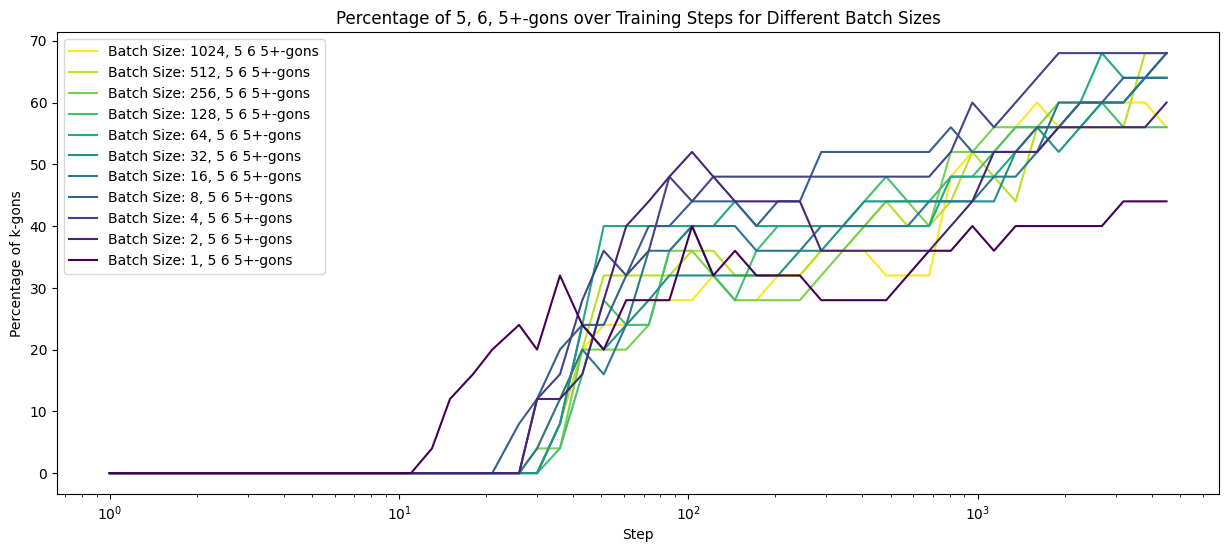

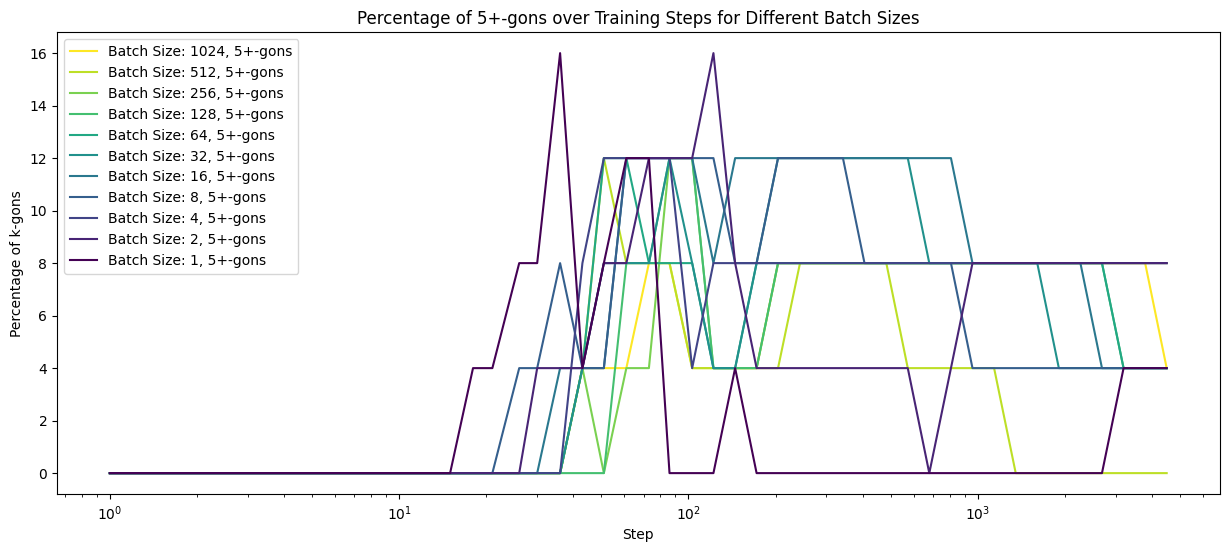

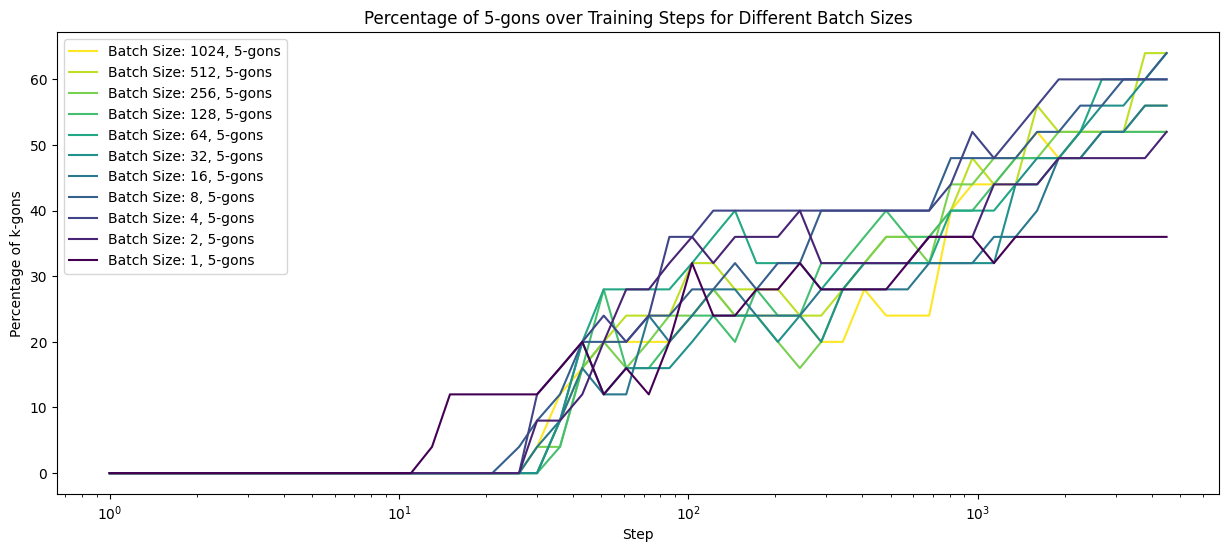

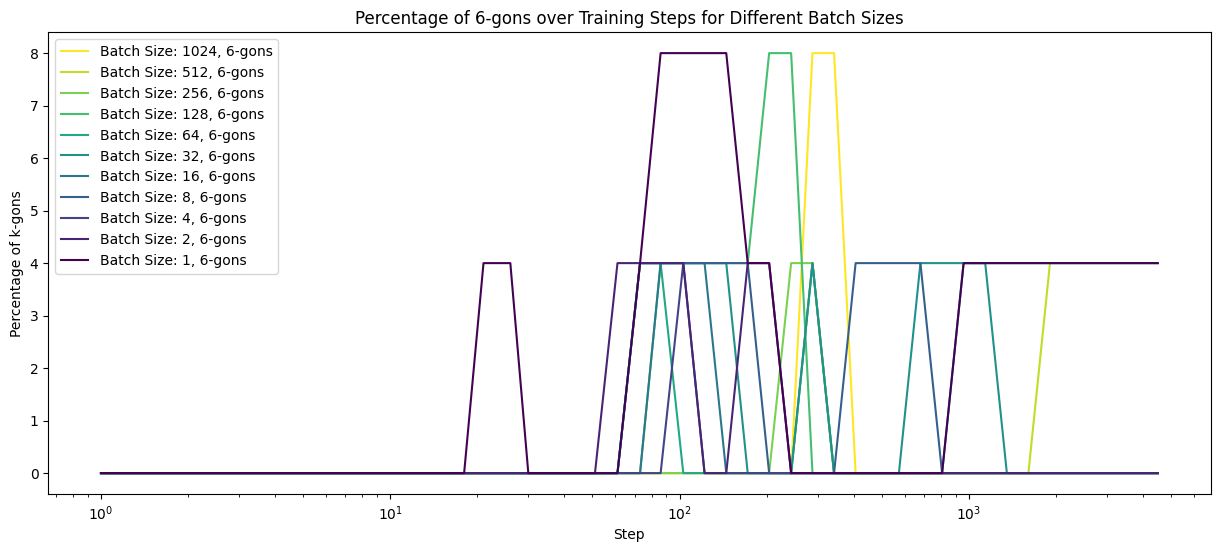

In [44]:
version = "v1.5.0"
print(version)

# Assuming 'batch_weights' is your dictionary of weights, 'STEPS' is your list of timesteps
plot_percentage_of_kgons_over_time(batch_weights[version], STEPS[version],k_values=[5, 6,"5+"])

plot_percentage_of_kgons_over_time(batch_weights[version],STEPS[version], k_values=["5+"])
plot_percentage_of_kgons_over_time(batch_weights[version], STEPS[version], k_values=[5])    
plot_percentage_of_kgons_over_time(batch_weights[version],STEPS[version], k_values=[6])

Since this is not quite as visible above we plot the mean of the last recorded % of 5 and 6-gons against batchsize here:

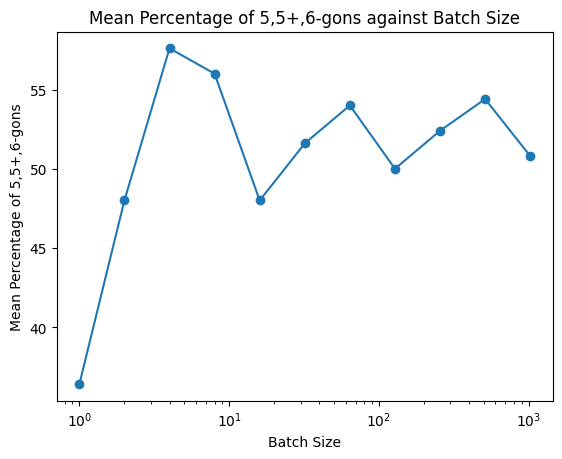

In [44]:
version = "v1.5.0"
kgon_percentages = compute_kgon_percentages(batch_weights[version], STEPS[version], k_values=[5, 6, "5+"])


# Calculate a single metric for each batch size - for example, the mean of the last N percentages
N = 10  # Number of points to consider from the end of the list
metric_by_batch_size = {
    batch_size: np.mean(values[5][-N:]) for batch_size, values in kgon_percentages.items()
}

# Sort the batch sizes and corresponding metrics
sorted_batch_sizes = np.array(sorted(metric_by_batch_size.keys()))
sorted_metrics = np.array([metric_by_batch_size[bs] for bs in sorted_batch_sizes])

# Plot mean percentage of 5>-gons against batch size
plt.plot(sorted_batch_sizes, sorted_metrics, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Mean Percentage of 5,5+,6-gons')
plt.title('Mean Percentage of 5,5+,6-gons against Batch Size')
plt.xscale('log')  # Batch sizes are typically in a logarithmic scale
plt.show()

v1.12.0


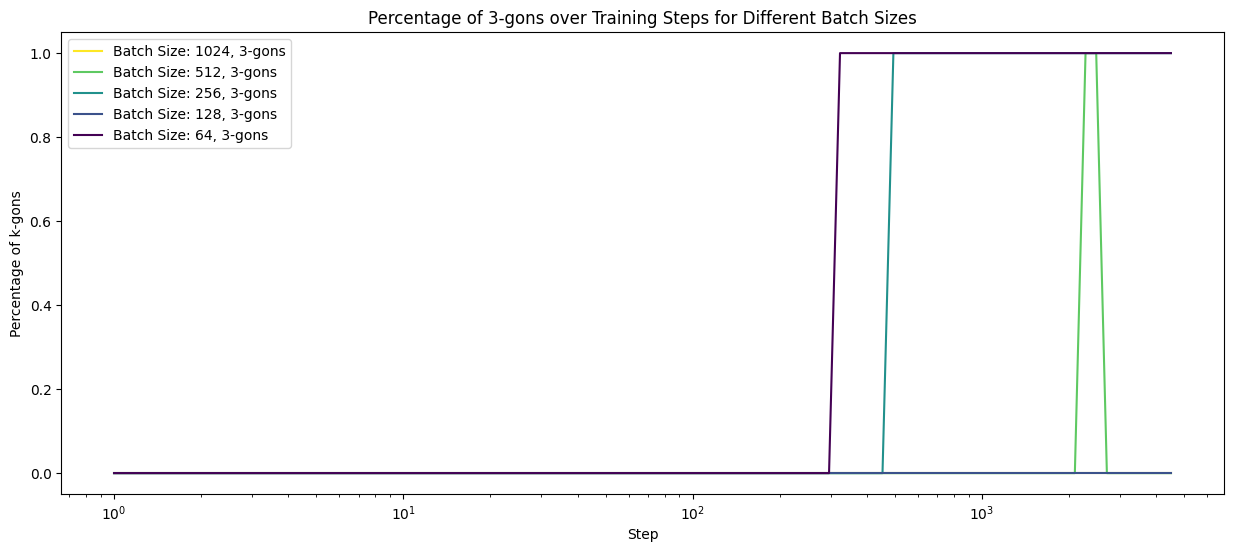

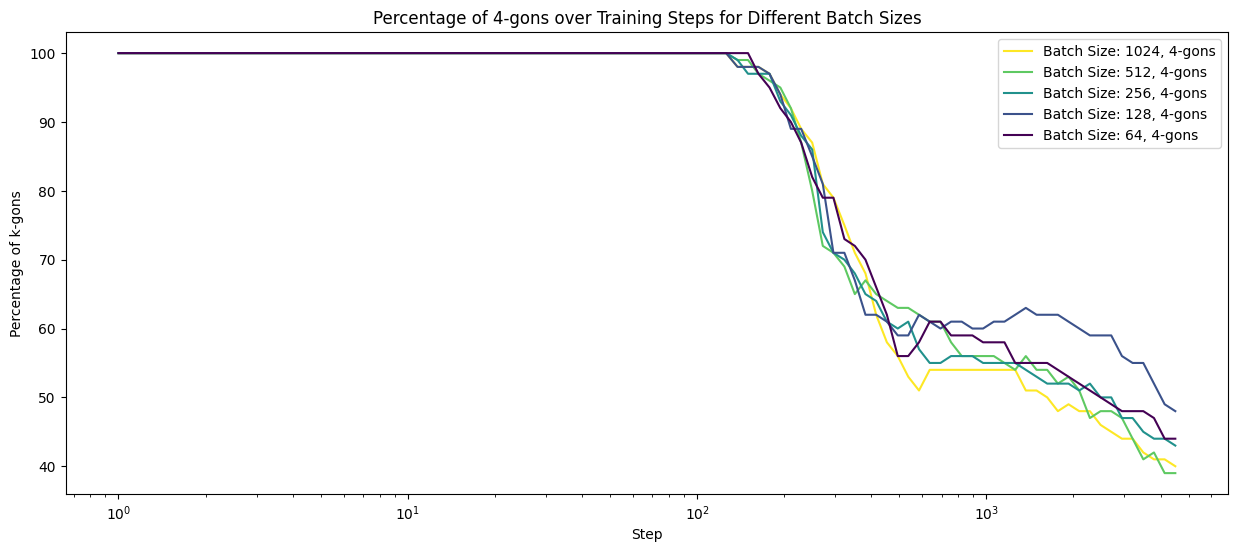

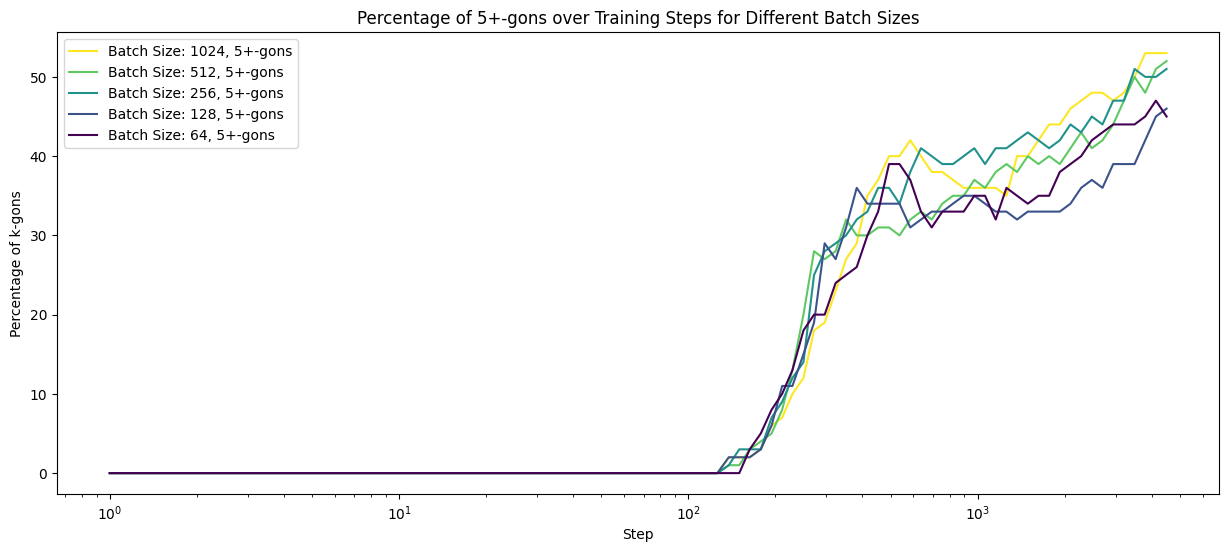

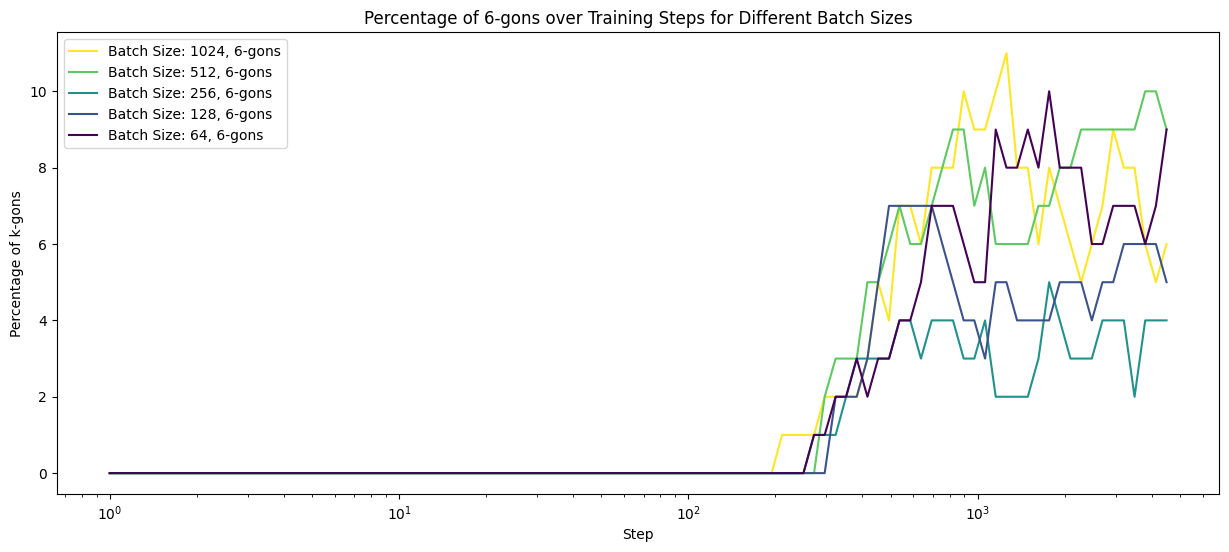

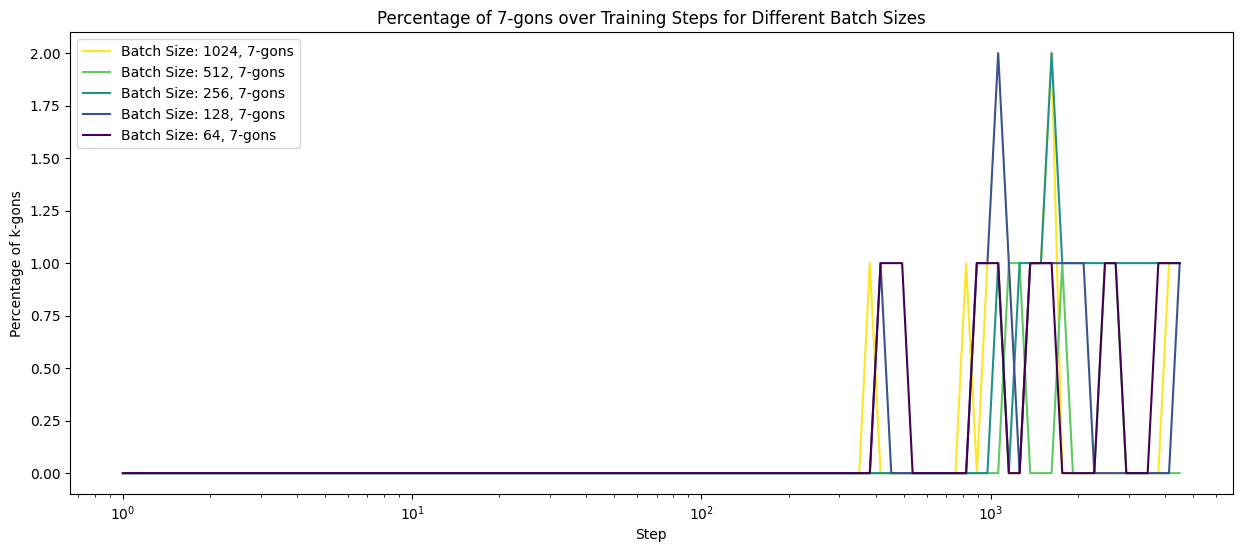

In [49]:
for version in versions.keys():
    if version not in ["v1.12.0"]:
        continue
    print(version)
    
    # Assuming 'batch_weights' is your dictionary of weights, 'STEPS' is your list of timesteps
    for i in range(3,8):
        if i==5:
            plot_percentage_of_kgons_over_time(batch_weights[version],STEPS[version], k_values=["5+"])
        else:
            plot_percentage_of_kgons_over_time(batch_weights[version], STEPS[version],k_values=[i])
        
            
    #plot_percentage_of_kgons_over_time(batch_weights[version], STEPS[version],k_values=list(range(3,21)))

v1.6.0


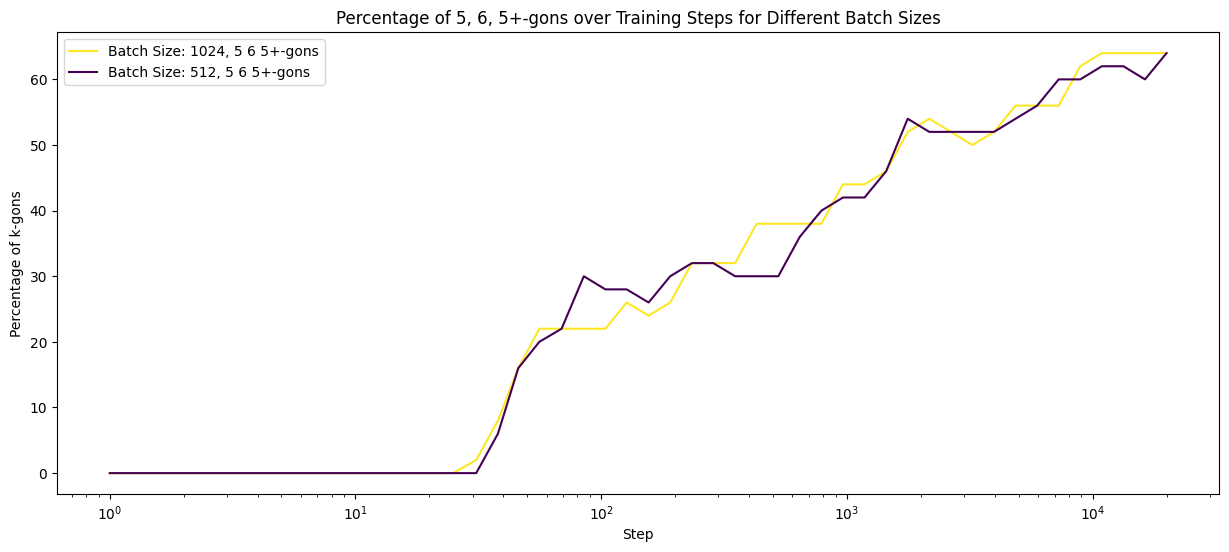

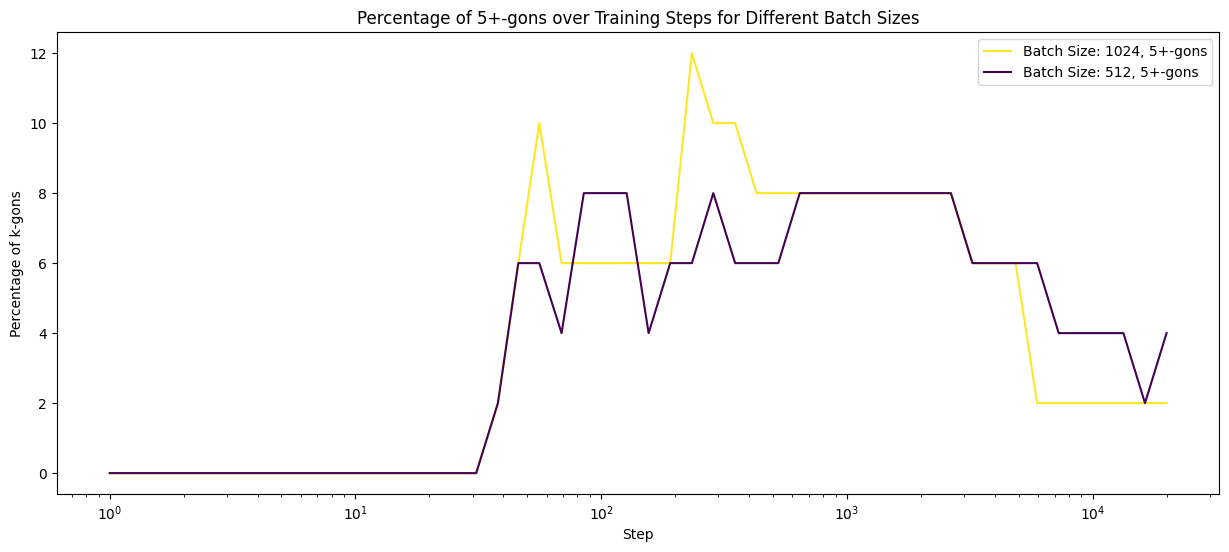

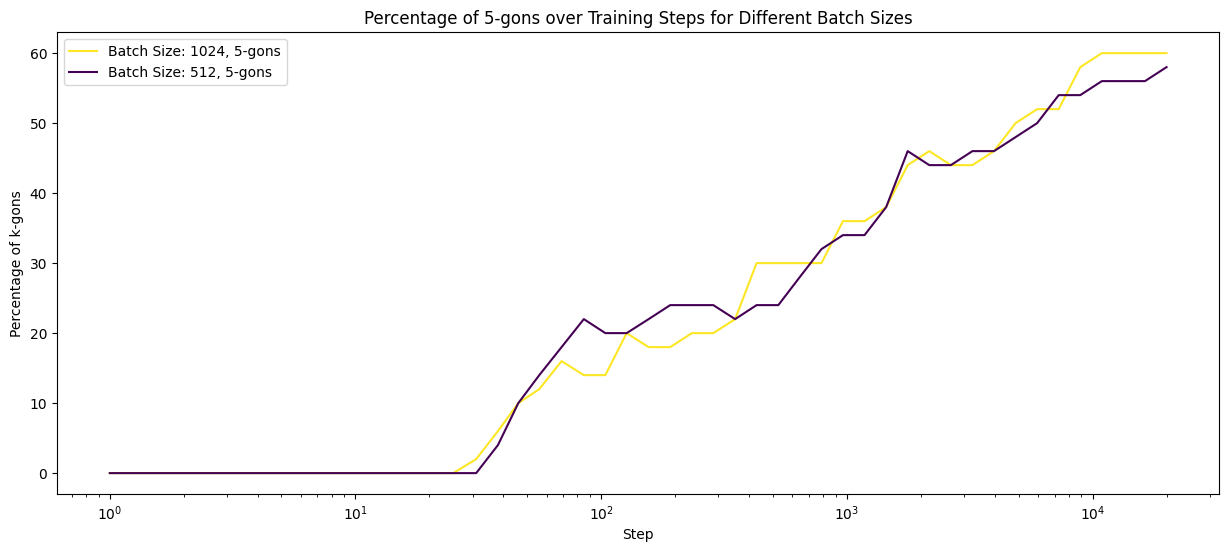

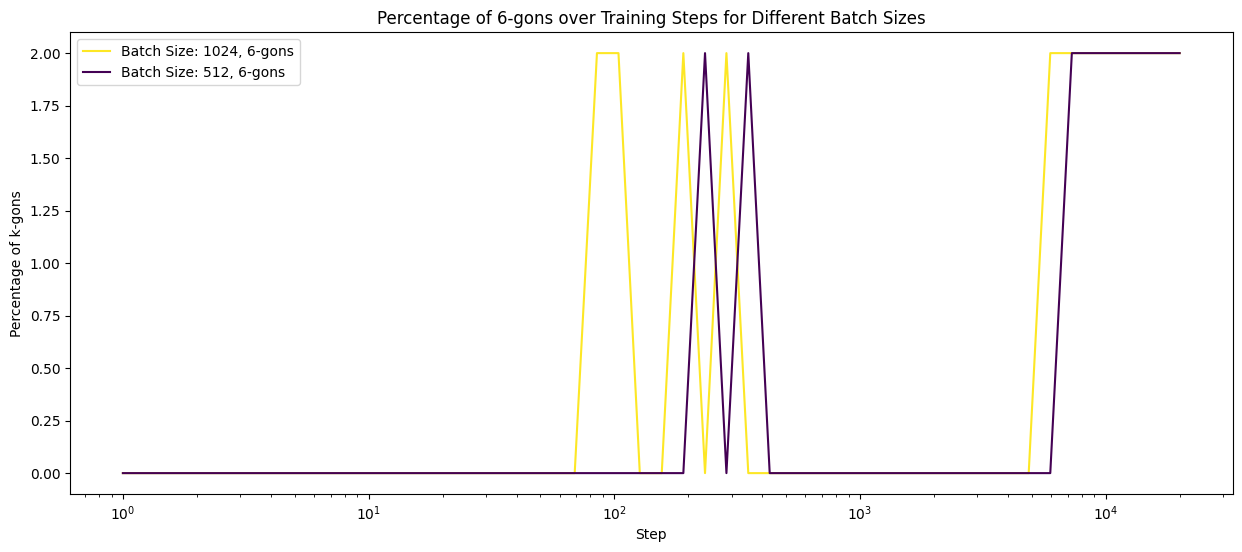

v1.10.0


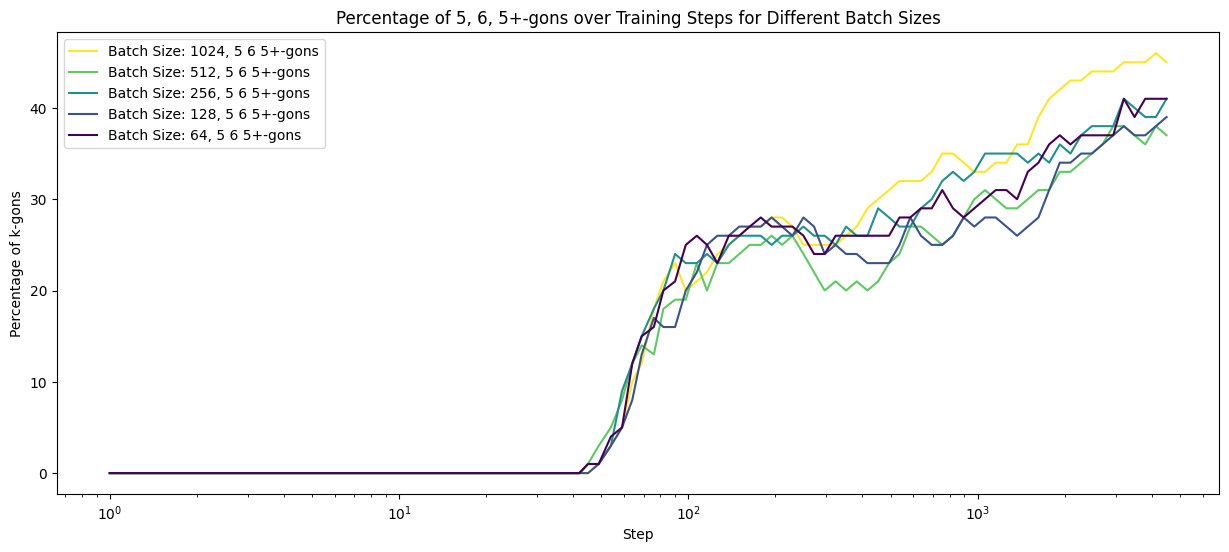

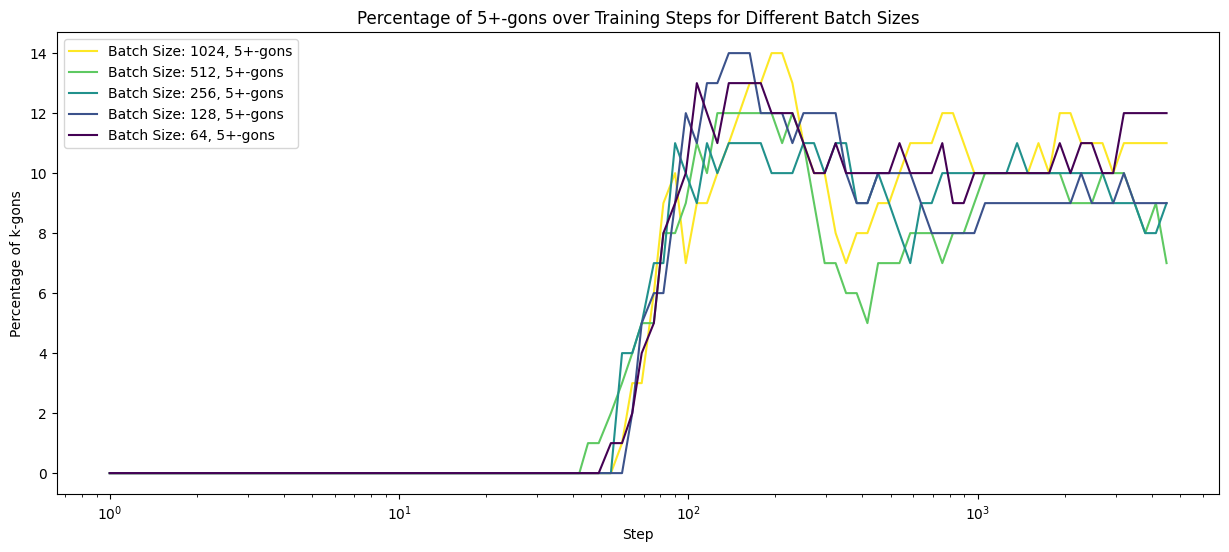

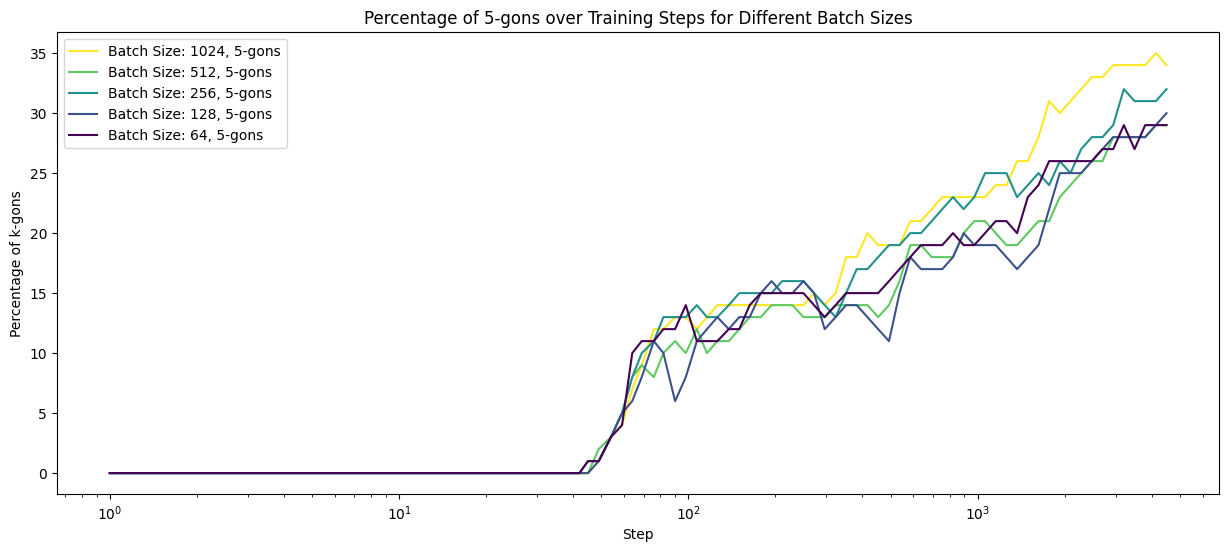

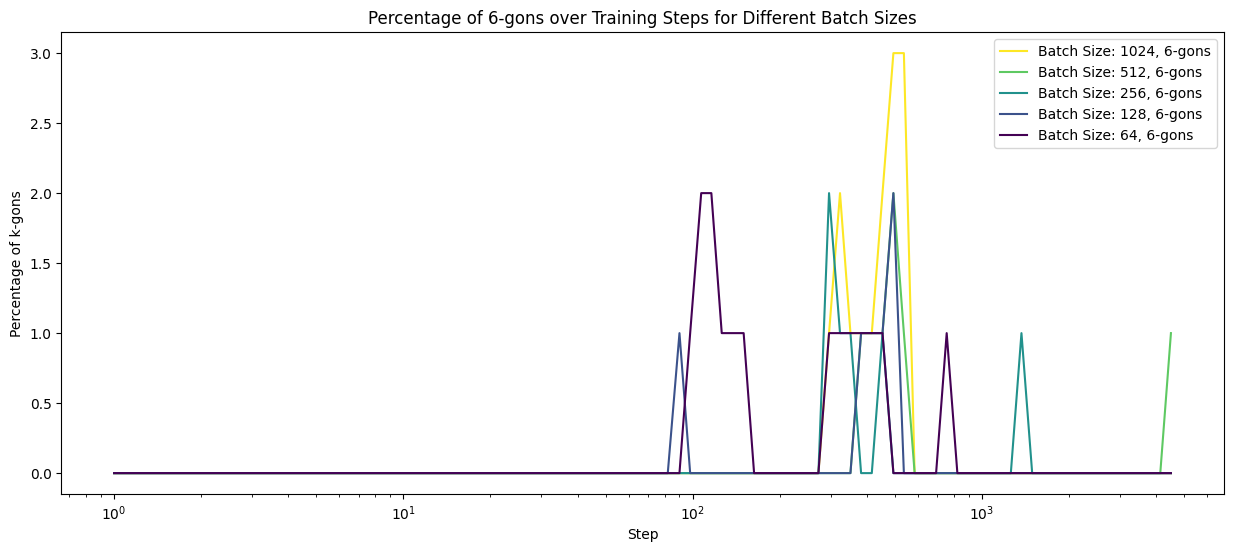

In [8]:
for version in versions.keys():
    if version not in ["v1.10.0","v1.6.0"]:
        continue
    print(version)
    
    # Assuming 'batch_weights' is your dictionary of weights, 'STEPS' is your list of timesteps
    plot_percentage_of_kgons_over_time(batch_weights[version], STEPS[version],k_values=[5, 6,"5+"])

    plot_percentage_of_kgons_over_time(batch_weights[version],STEPS[version], k_values=["5+"])
    plot_percentage_of_kgons_over_time(batch_weights[version], STEPS[version], k_values=[5])    
    plot_percentage_of_kgons_over_time(batch_weights[version],STEPS[version], k_values=[6])

Below we plot all runs that eventually led to a hexagon:

Below we take a closer look at run 1.12, where we use 20 in and output features for the autoencoder instead of 6. It can clearly be seen that 6-gons are developing earlier in this variant:

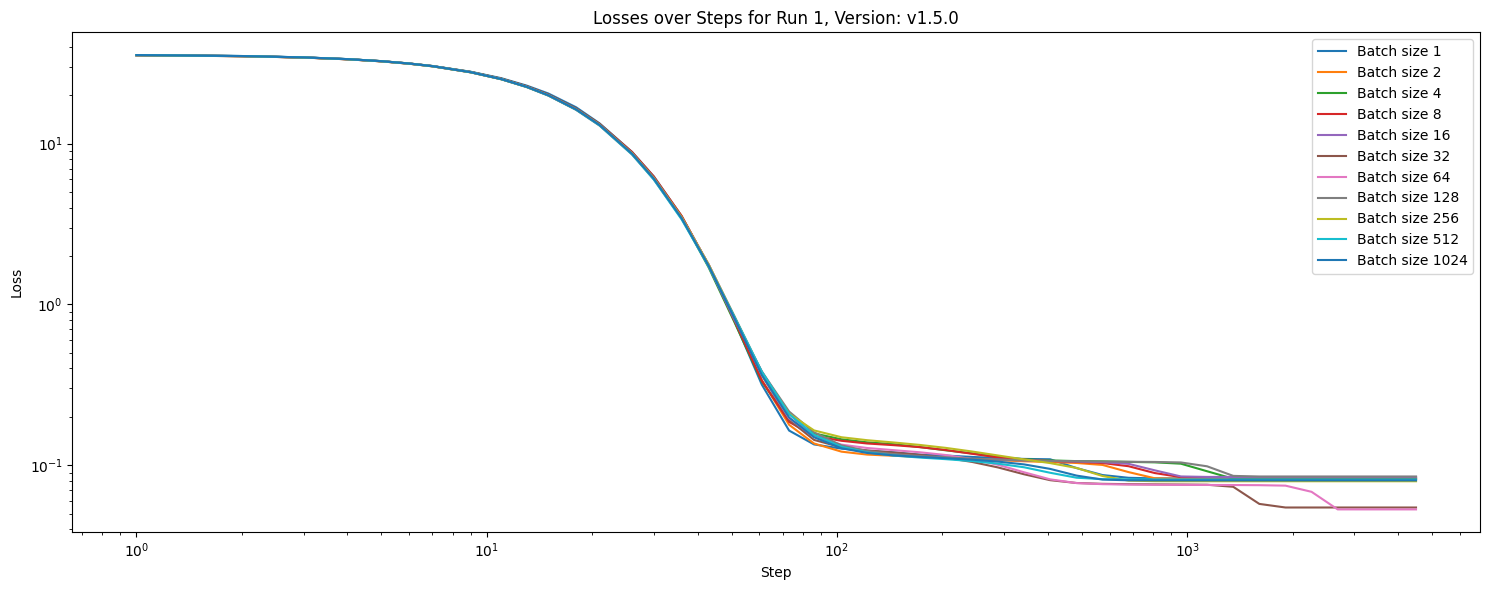

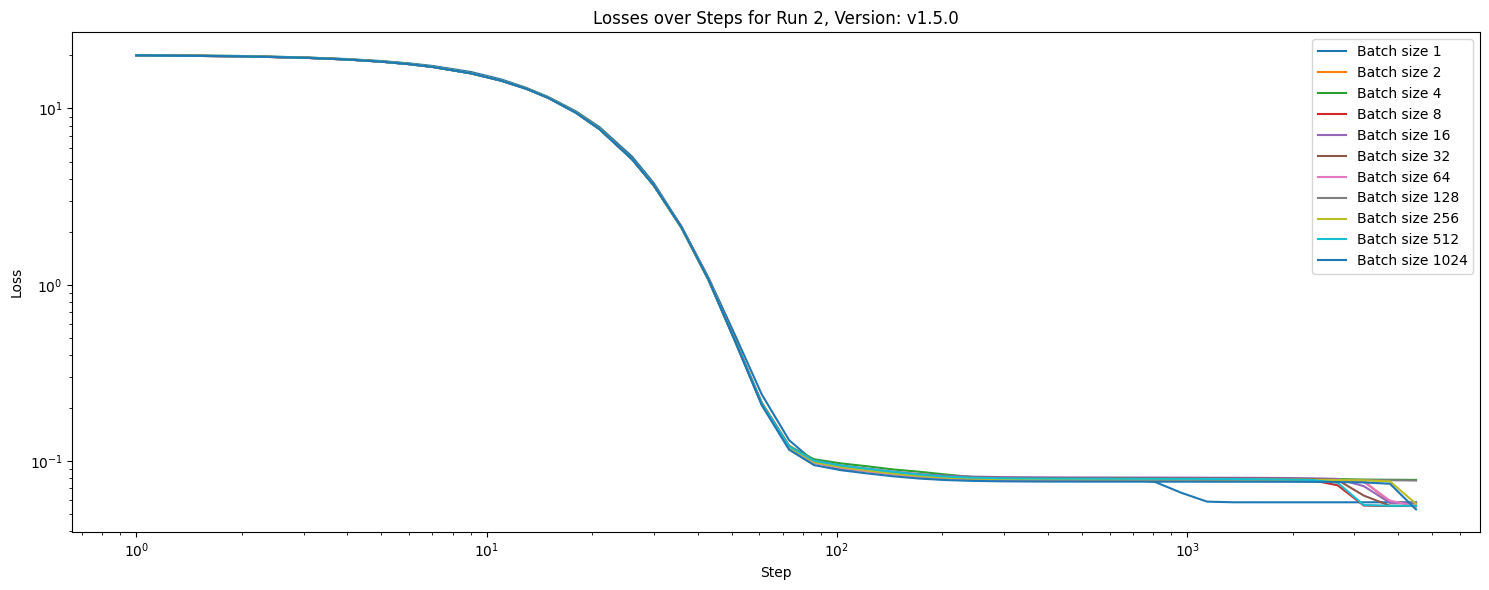

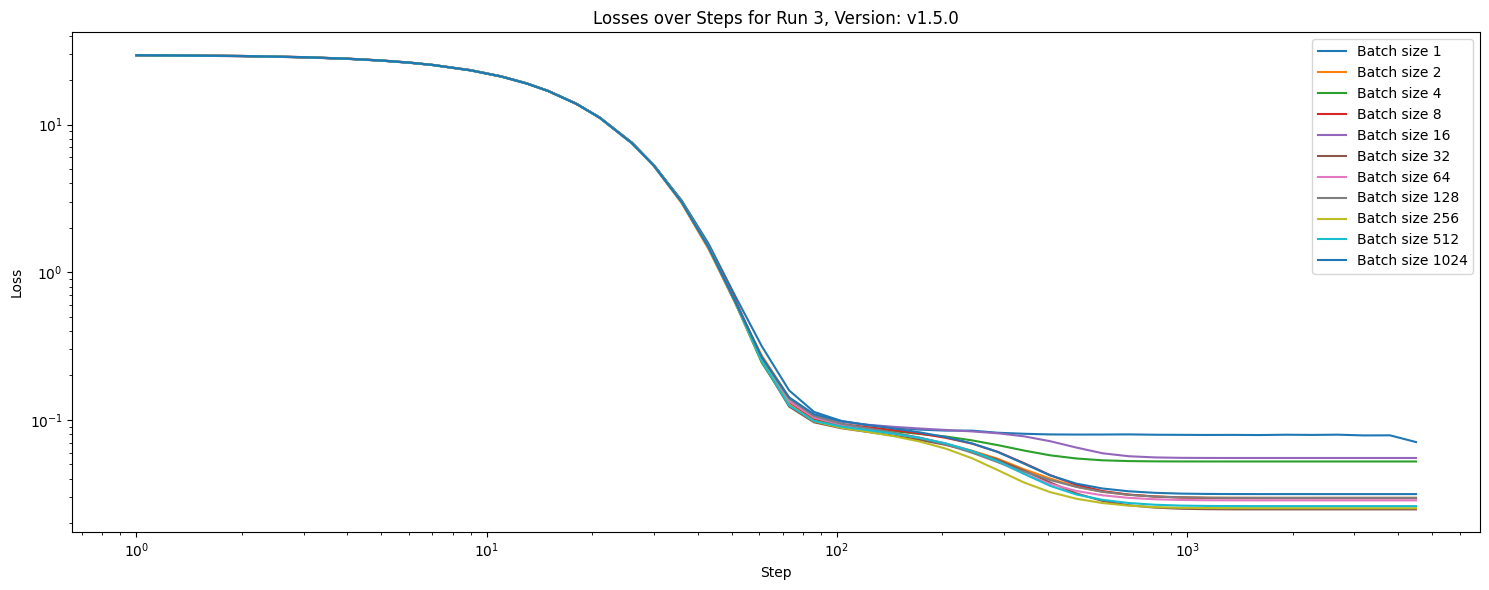

In [79]:
def plot_run_losses(num_runs, batch_sizes, batch_logs, steps, plot_steps, xscale="log", version = None):
    for i in range(num_runs):
        fig, ax = plt.subplots(figsize=(15, 6))
        
        for batch_size in batch_sizes:
            all_logs = batch_logs[batch_size]
            losses = [all_logs[i].loc[all_logs[i]['step'] == s, 'loss'].values[0] for s in steps]
            #            losses = [all_logs[run].loc[all_logs[run]['step'] == s, 'loss'].values[0] for s in STEPS[version]]
            ax.plot(steps, losses, label=f'Batch size {batch_size}')

        ax.set_xlabel("Step")
        ax.set_ylabel("Loss")
        ax.set_xscale(xscale)
        ax.set_yscale("log")
        version_str = f"Version: {version}" if version is not None else ""
        plt.title(f"Losses over Steps for Run {i+1}, " + version_str)
        ax.legend()
        plt.tight_layout()
        plt.show()
        if i >= 2:
            break

version = "v1.5.0"
num_runs = versions[version]["num_runs"]
# Example call to the new function
plot_run_losses(num_runs, batch_sizes[version], batch_logs[version], STEPS[version], PLOT_STEPS[version], version=version)

v1.5.0


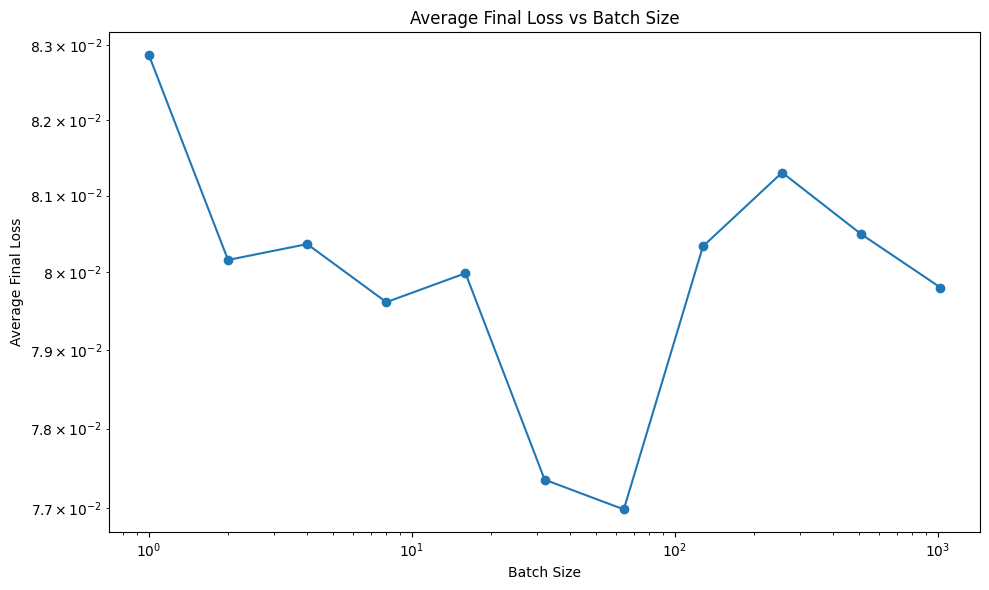

v1.12.0


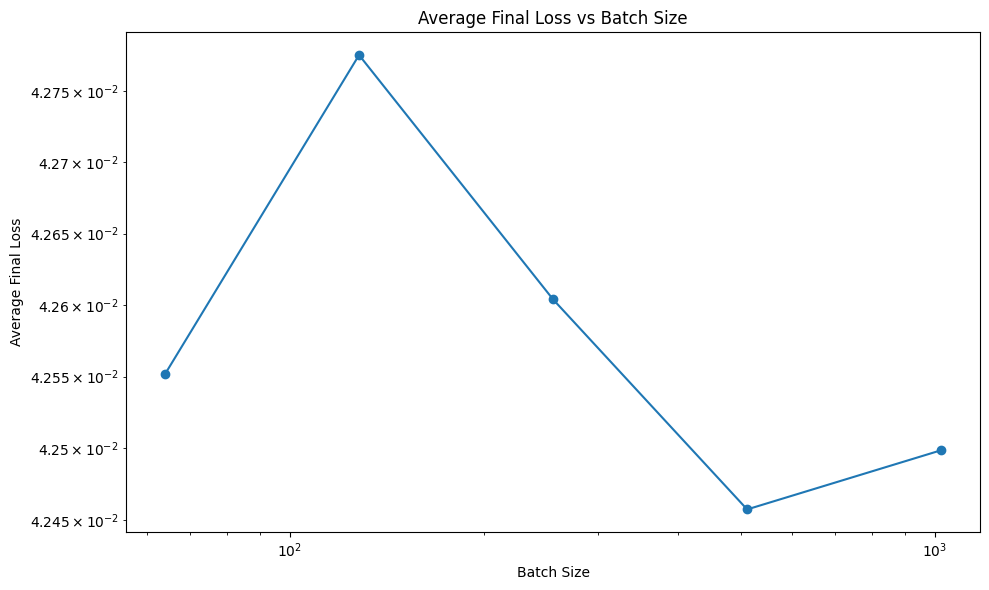

In [57]:

def plot_average_final_losses(batch_sizes, batch_logs, steps):
    average_final_losses = []

    for batch_size in batch_sizes:
        final_losses = []
        all_logs = batch_logs[batch_size]
        
        for run_logs in all_logs:
            # Assuming the final step's loss is what we want
            final_loss = run_logs.loc[run_logs['step'] == steps[-1], 'loss'].values[0]
            final_losses.append(final_loss)
        
        # Calculate average final loss for this batch size
        average_final_loss = np.mean(final_losses)
        average_final_losses.append(average_final_loss)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(batch_sizes, average_final_losses, marker='o', linestyle='-')
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Average Final Loss")
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.title("Average Final Loss vs Batch Size")
    plt.tight_layout()
    plt.show()
version = "v1.5.0"
# Example call to the new function
print(version)
plot_average_final_losses(batch_sizes[version], batch_logs[version], STEPS[version])
version = "v1.12.0"
print(version)
plot_average_final_losses(batch_sizes[version], batch_logs[version], STEPS[version])

### "Appendix"

Here are all hexagons and their training runs (excluding training runs that had an input larger than 8 features as that would give too many hits):

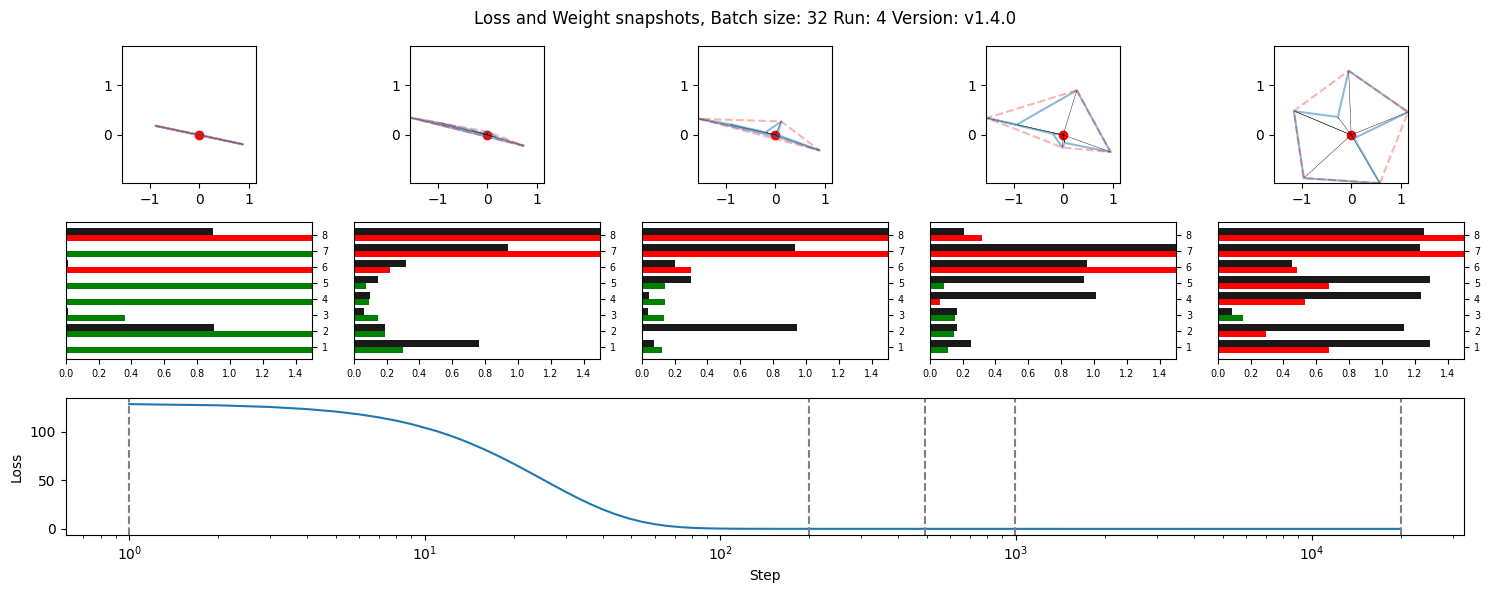

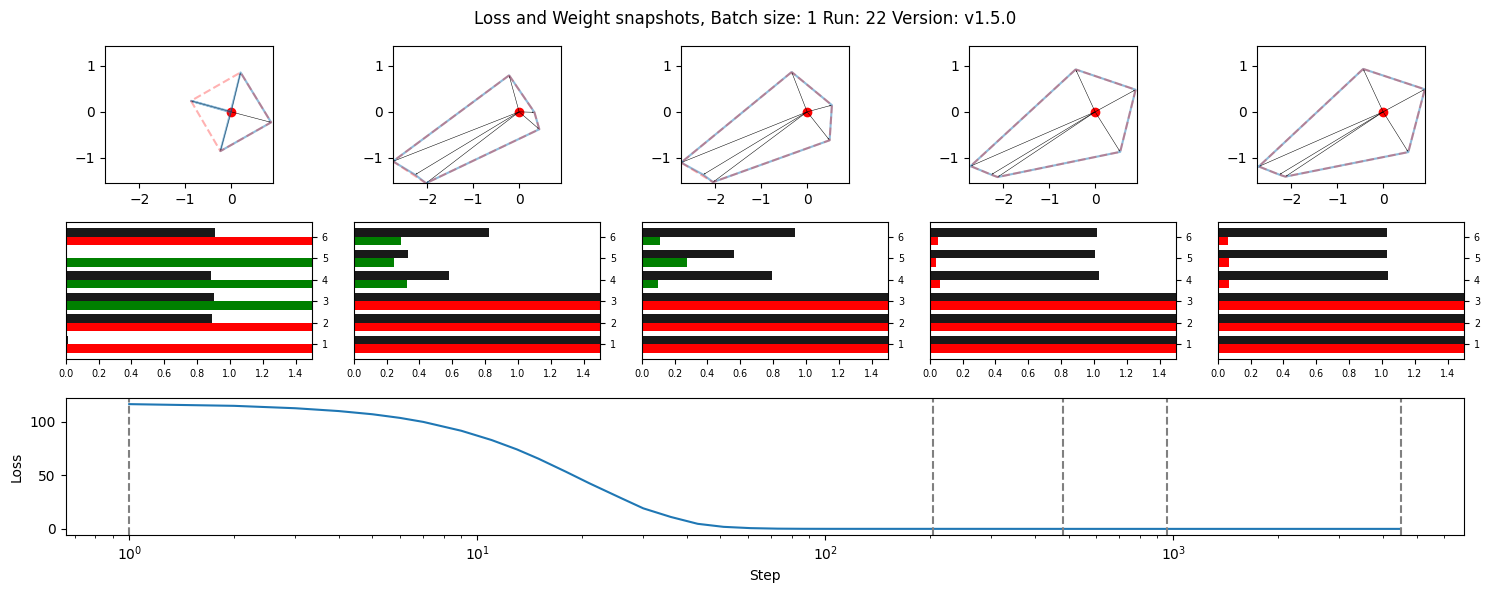

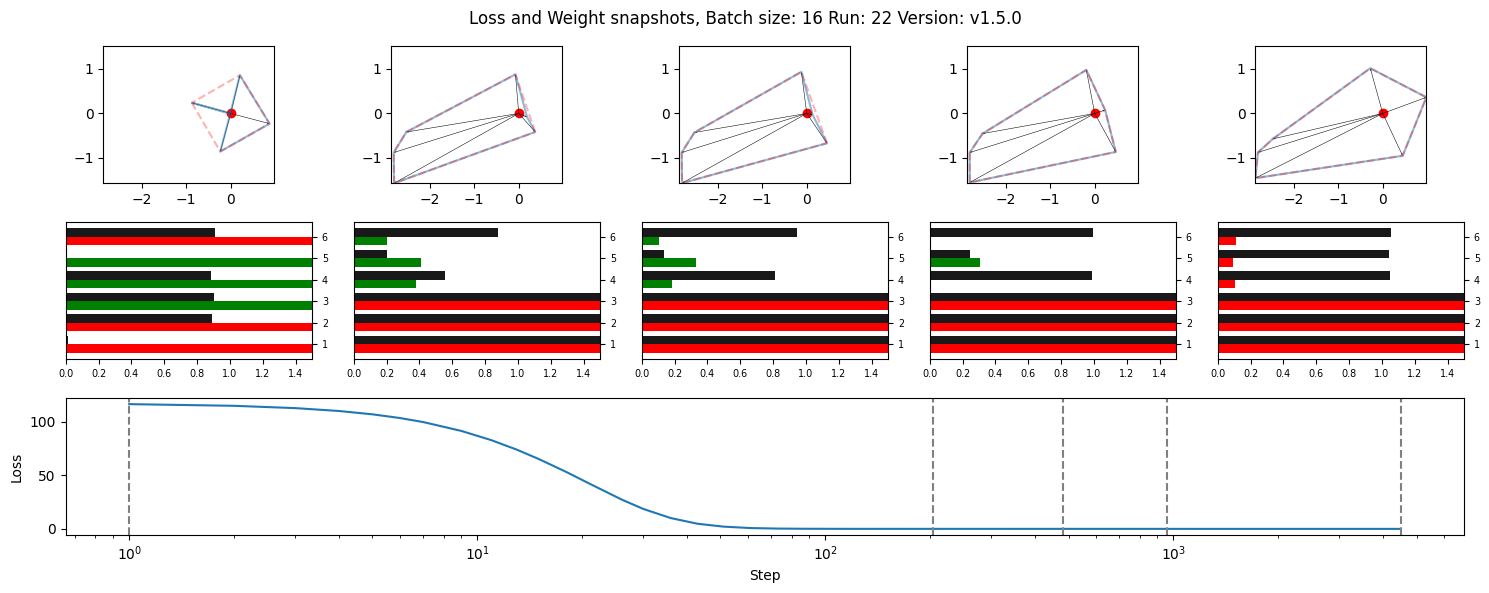

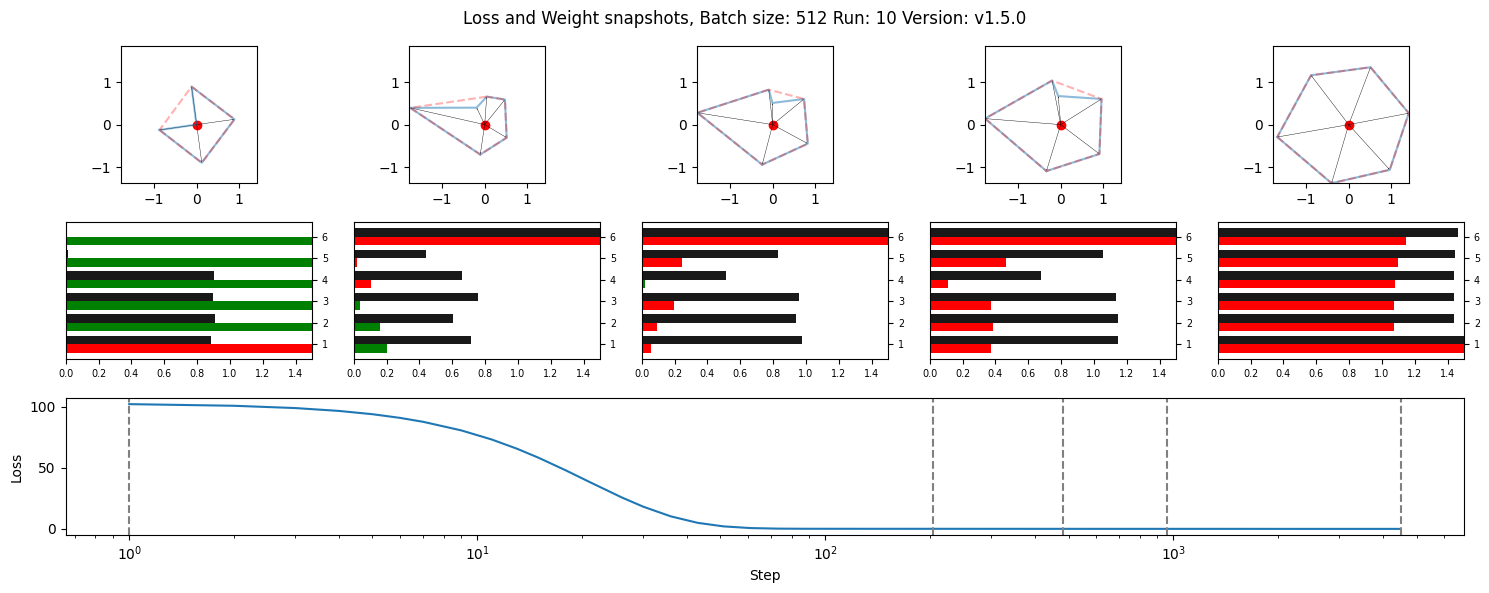

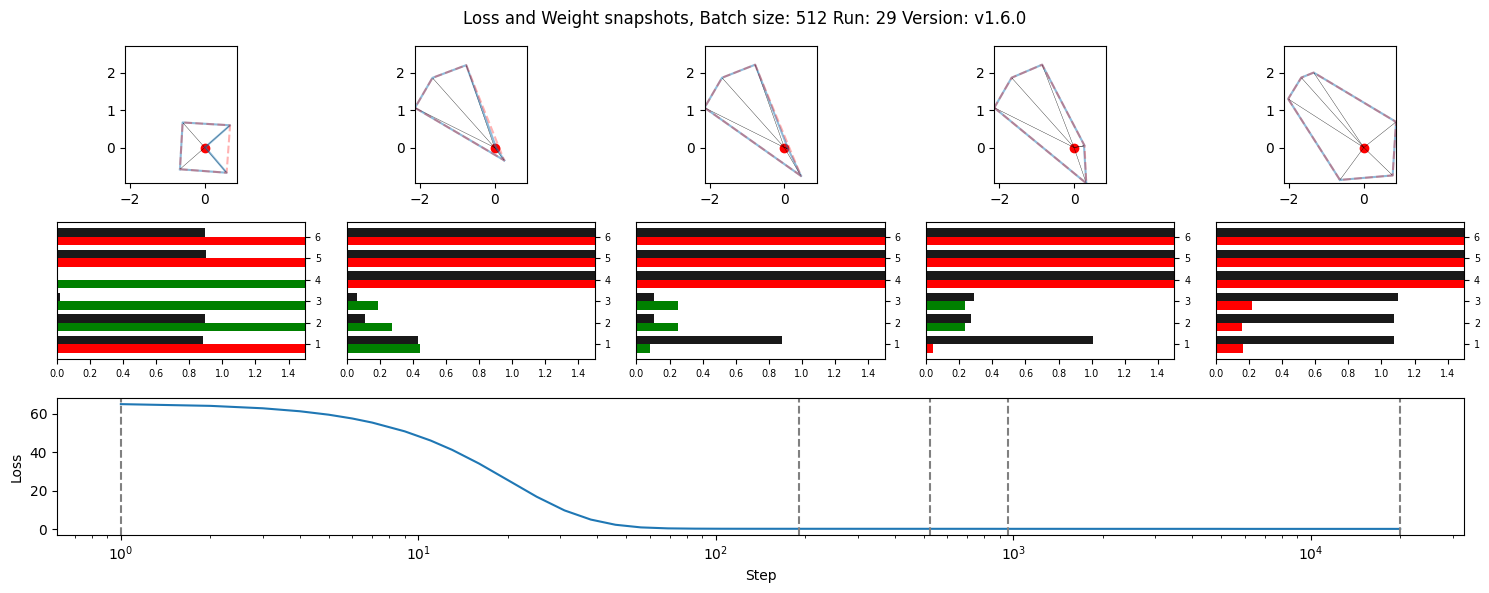

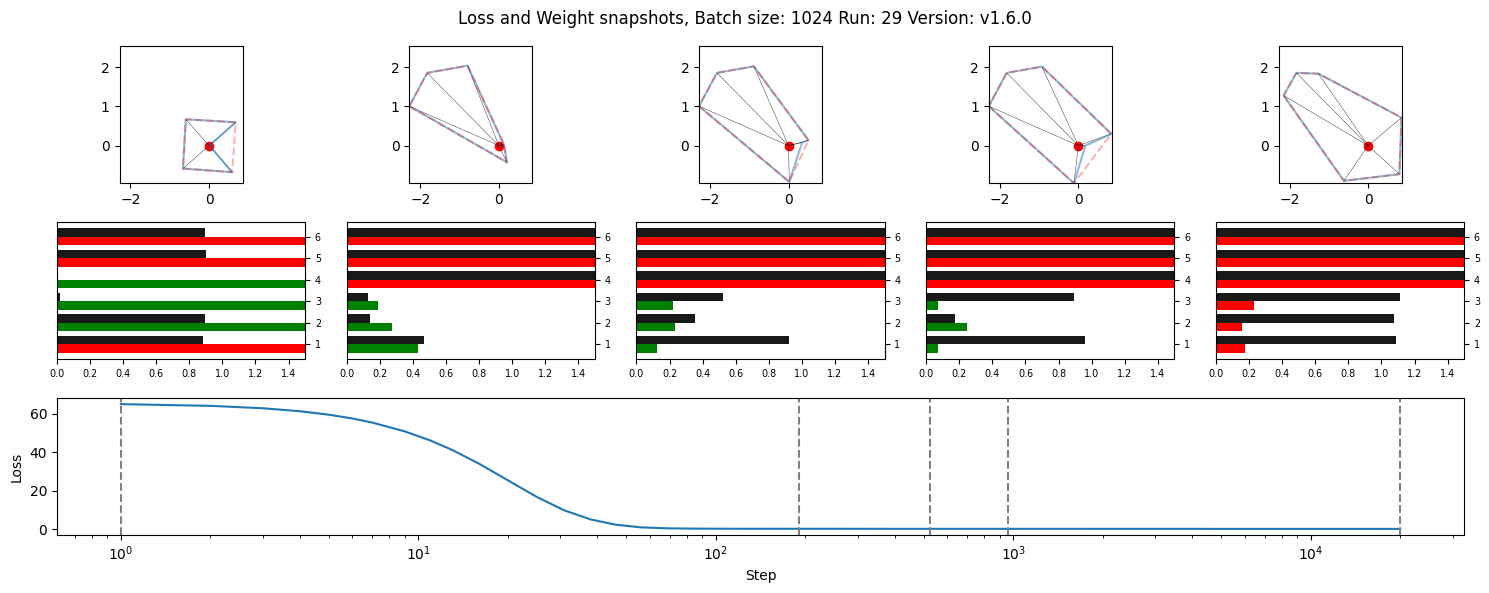

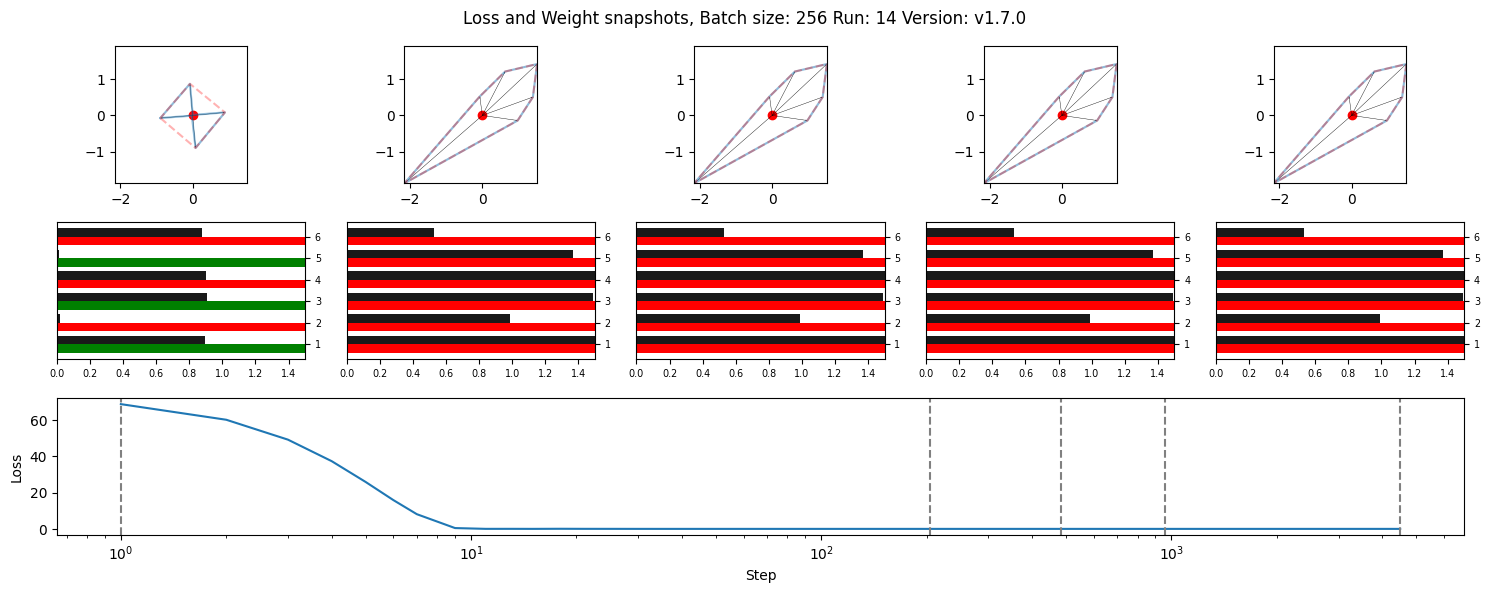

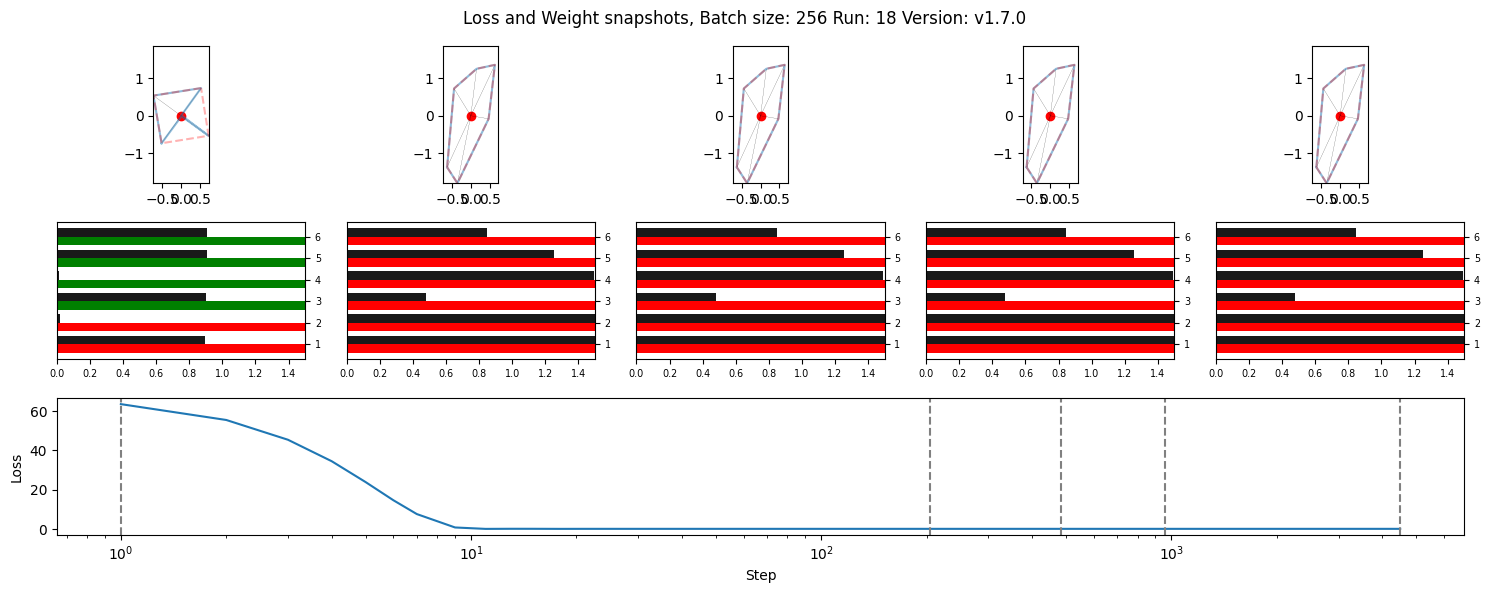

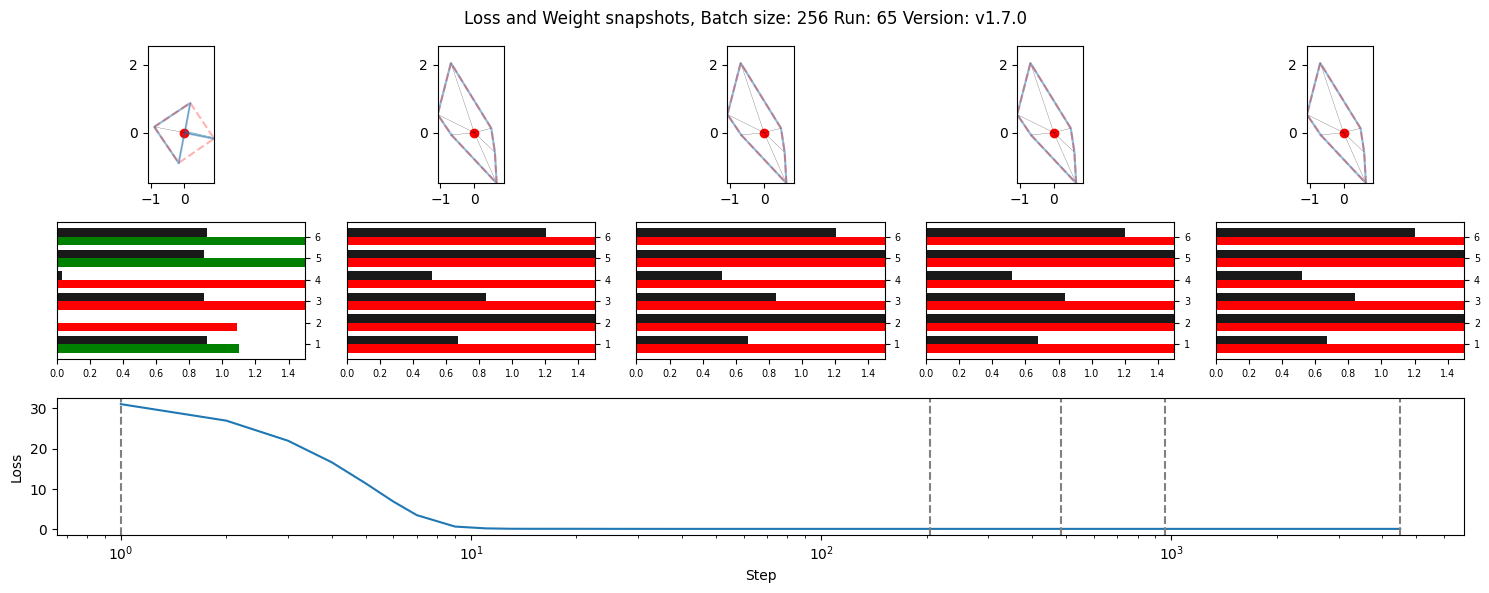

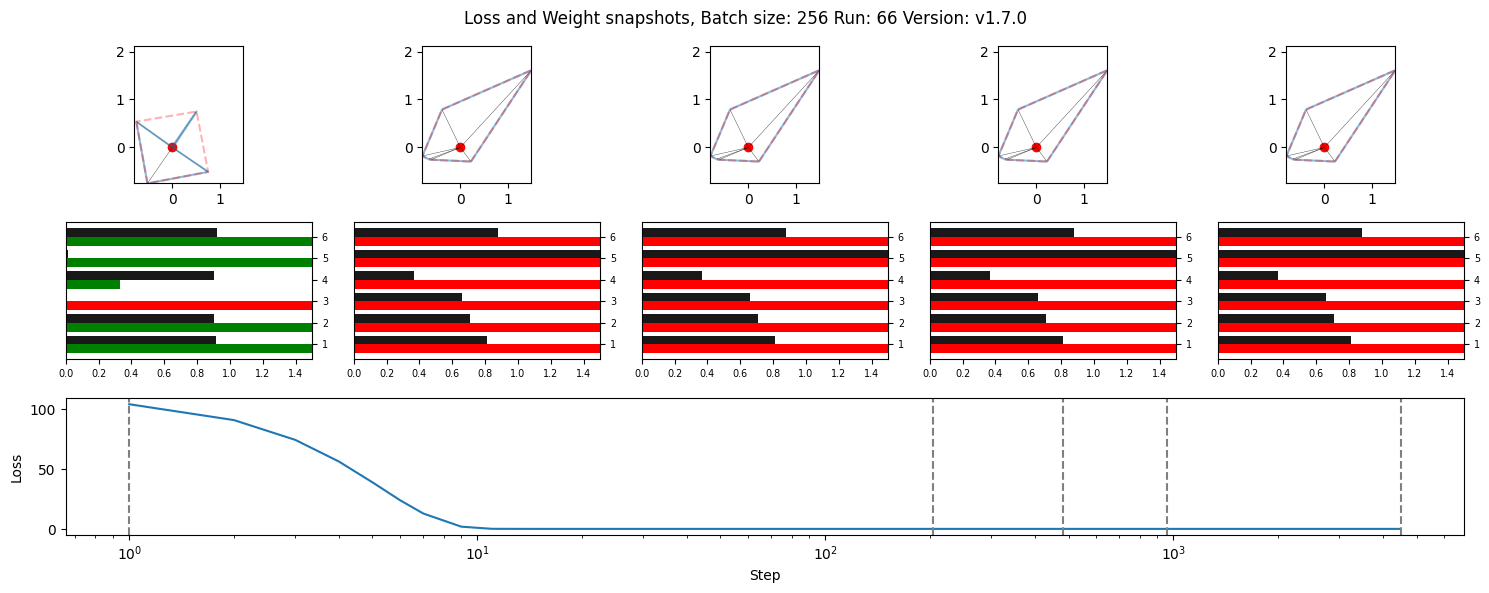

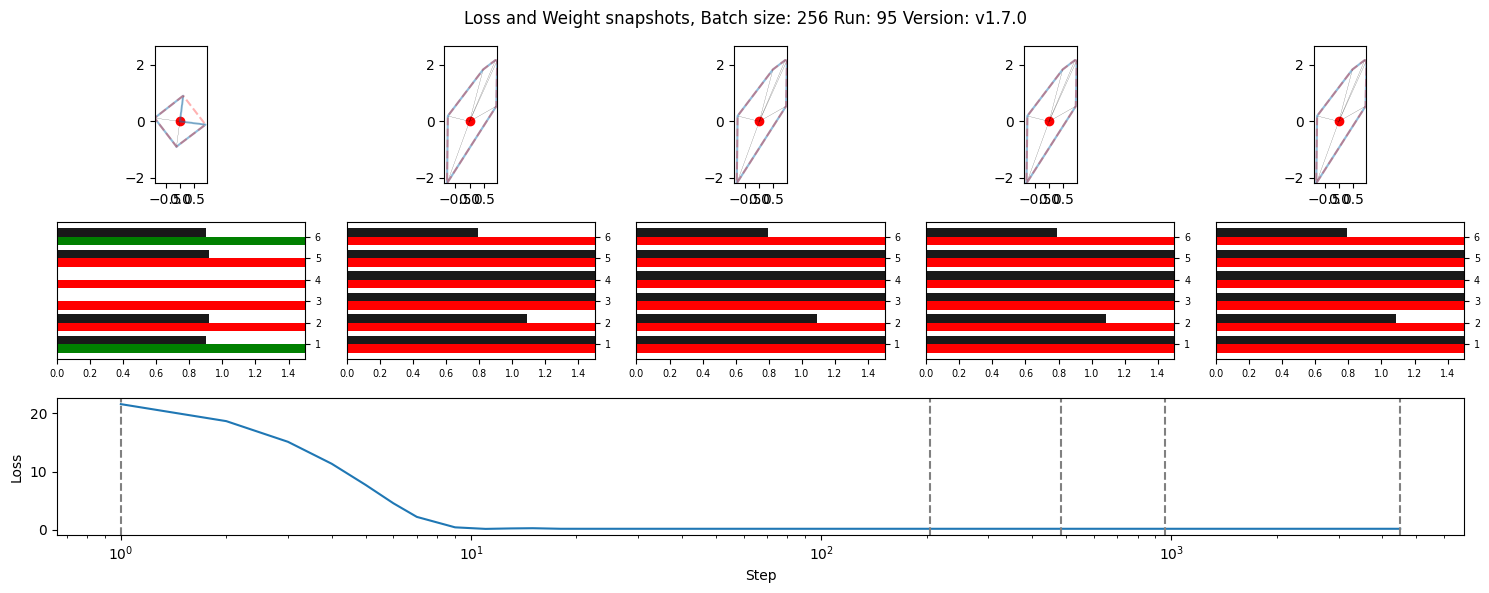

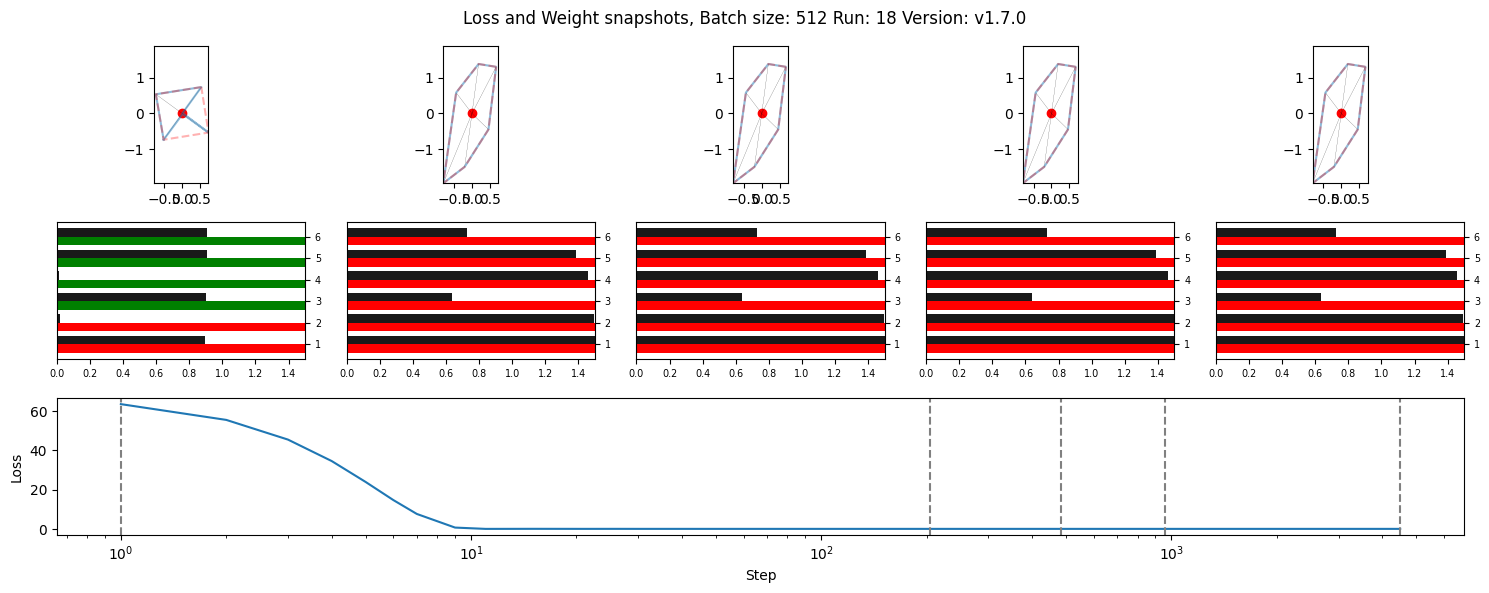

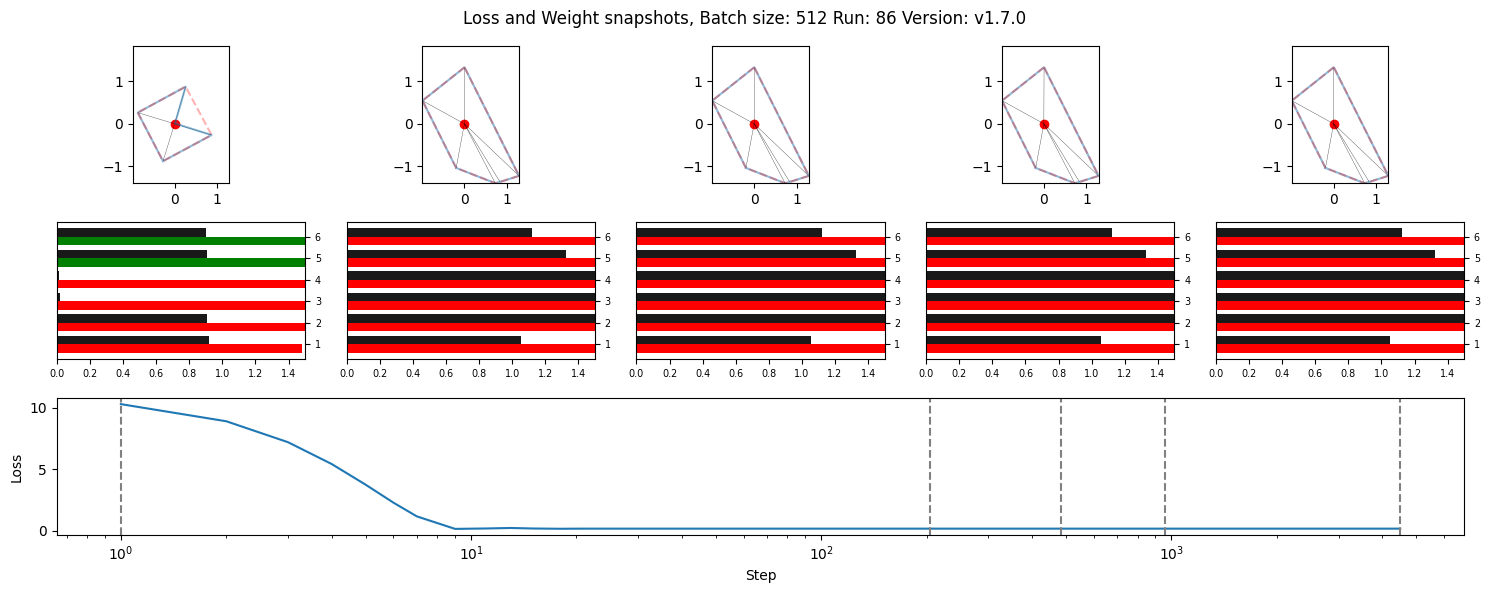

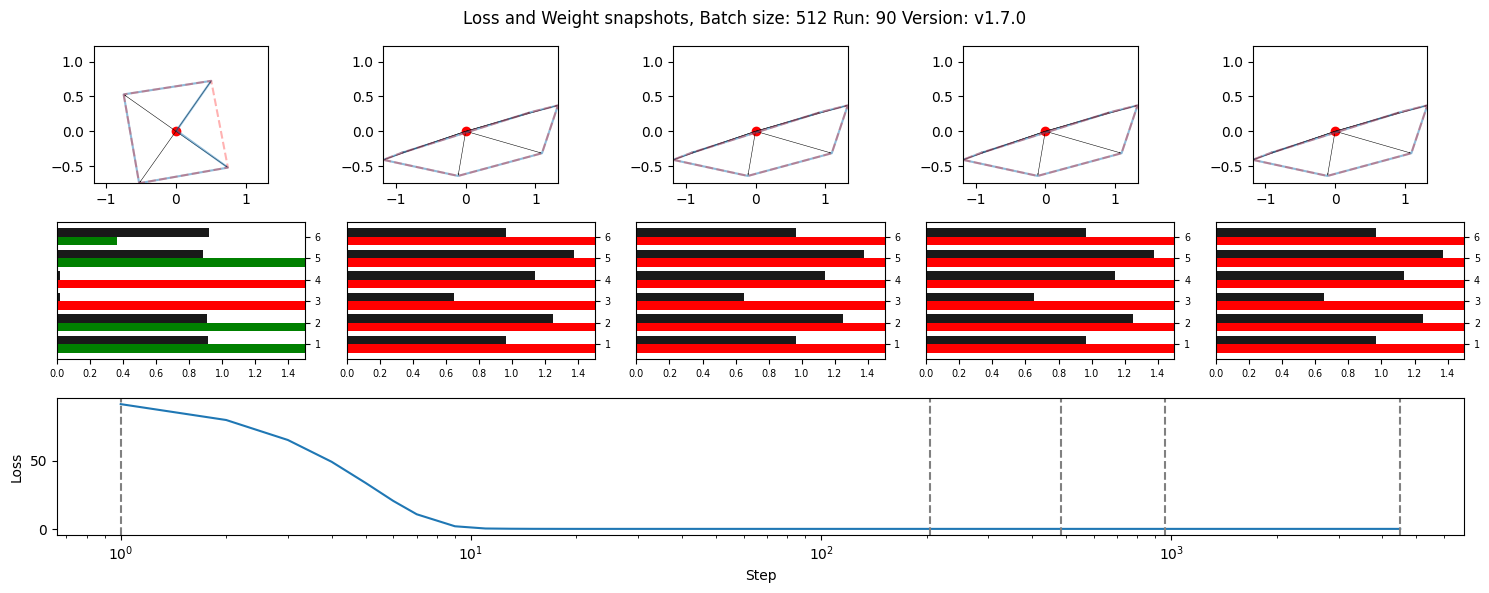

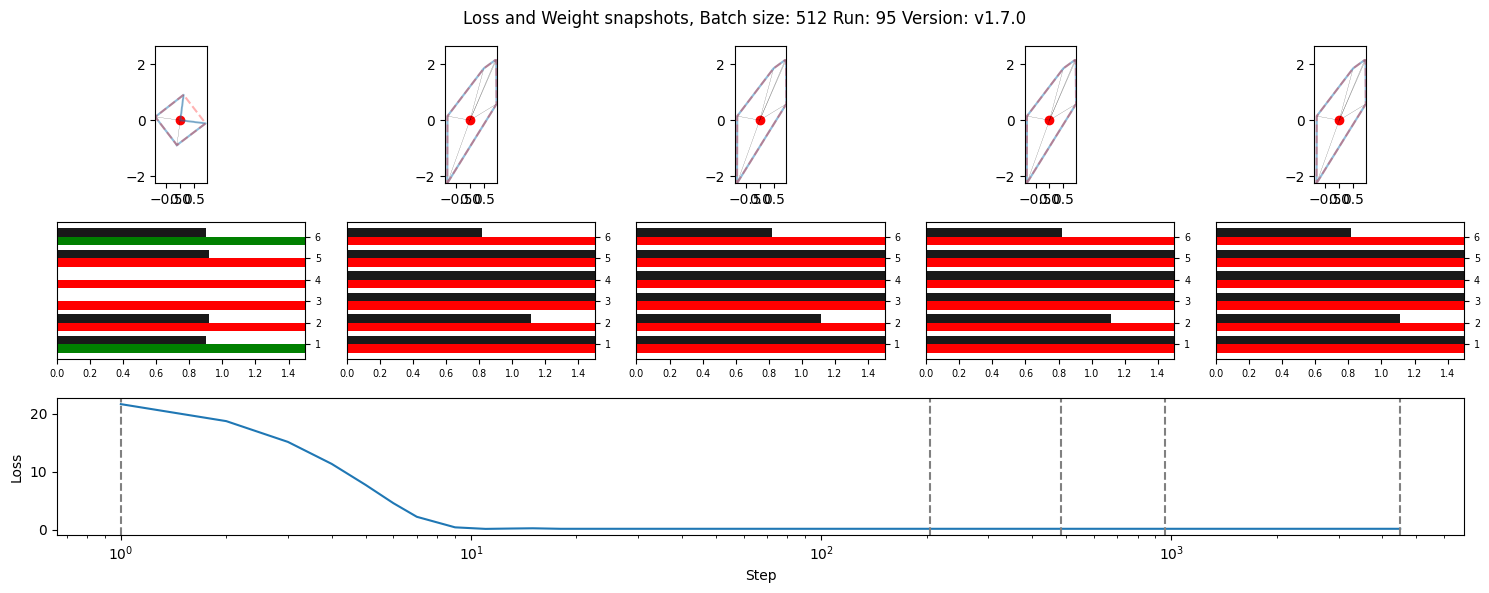

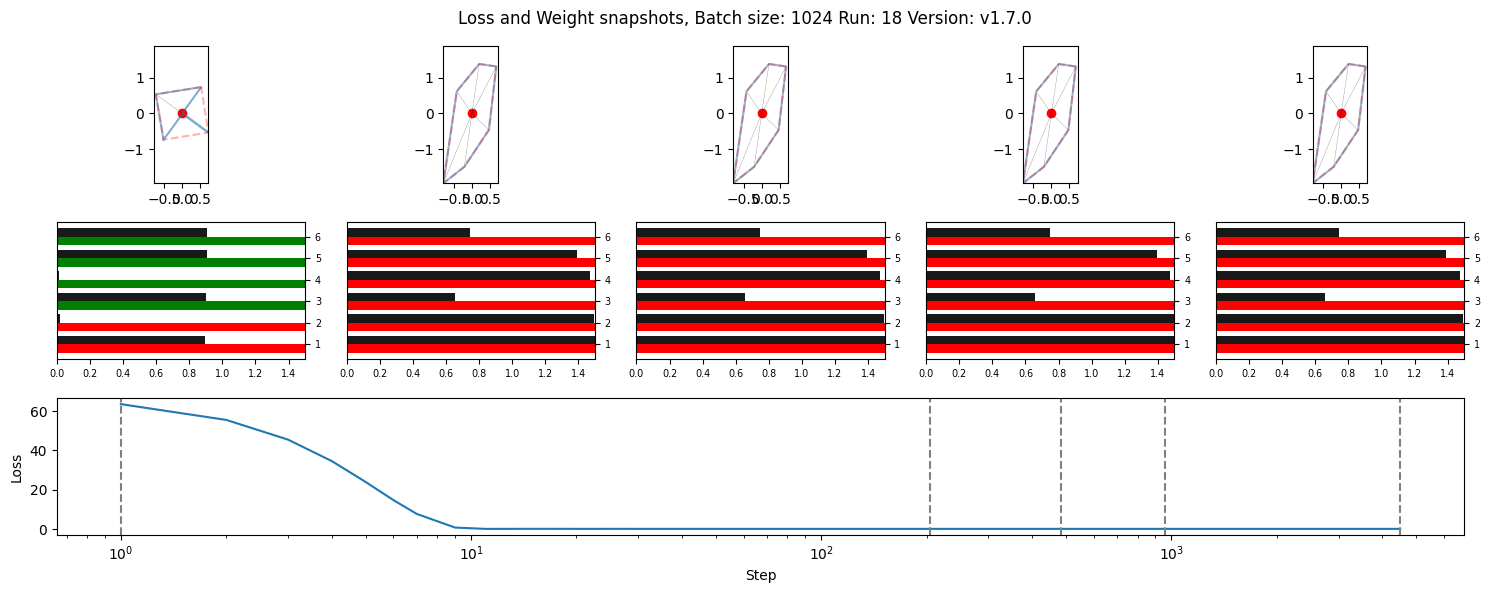

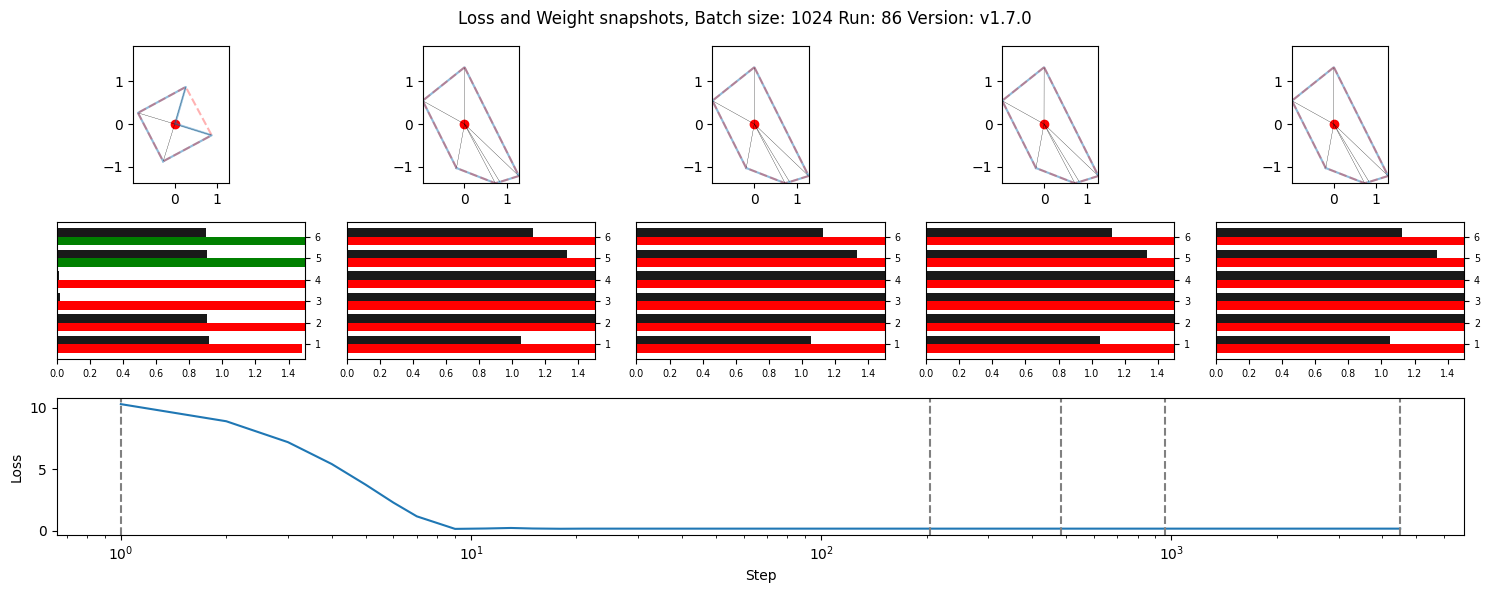

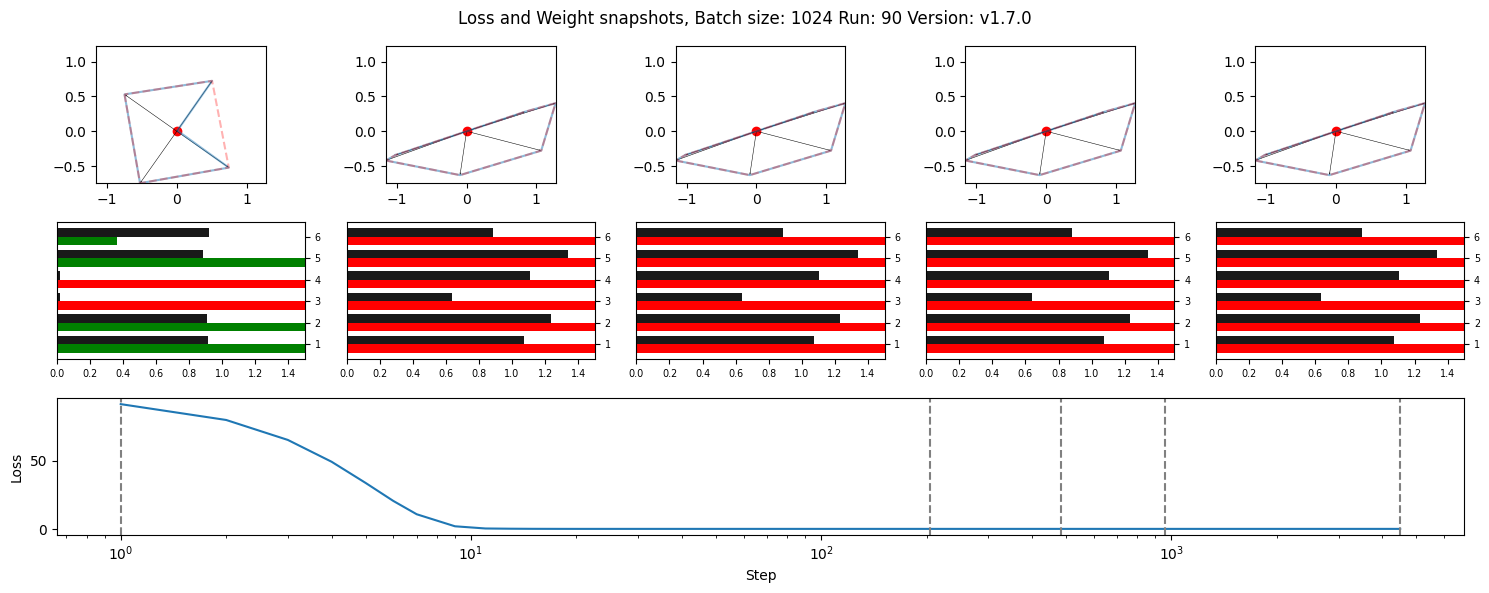

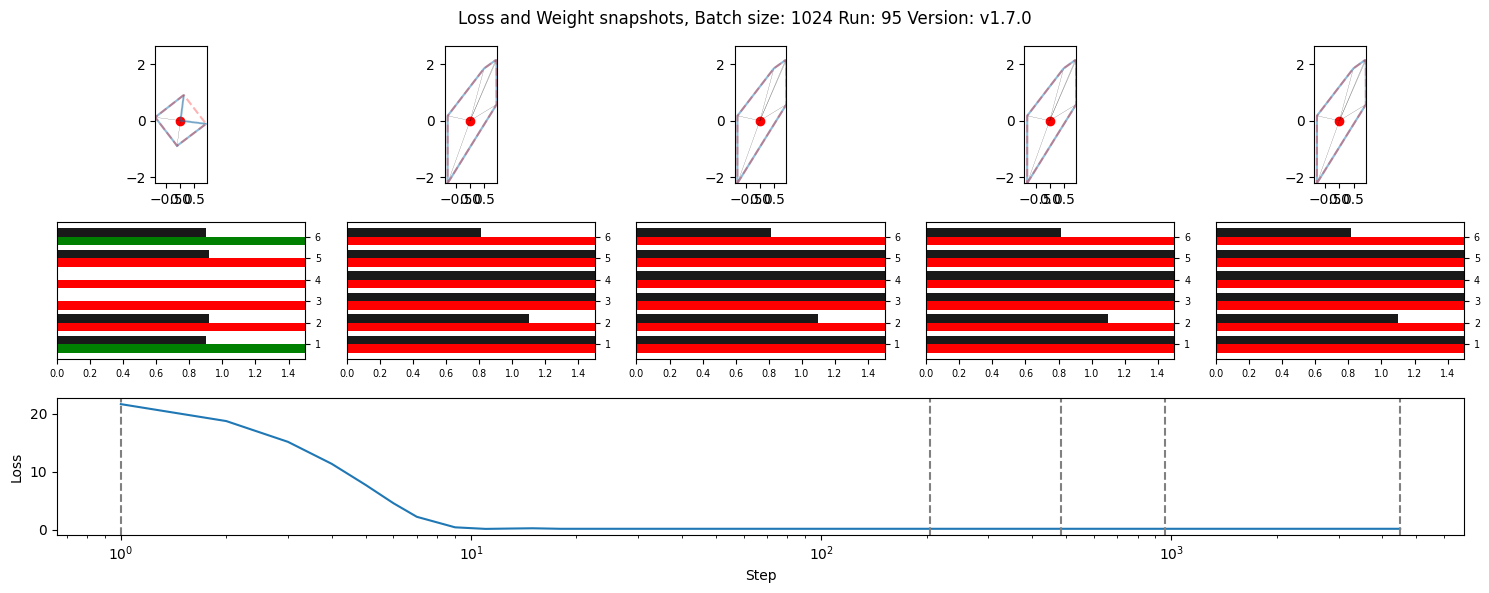

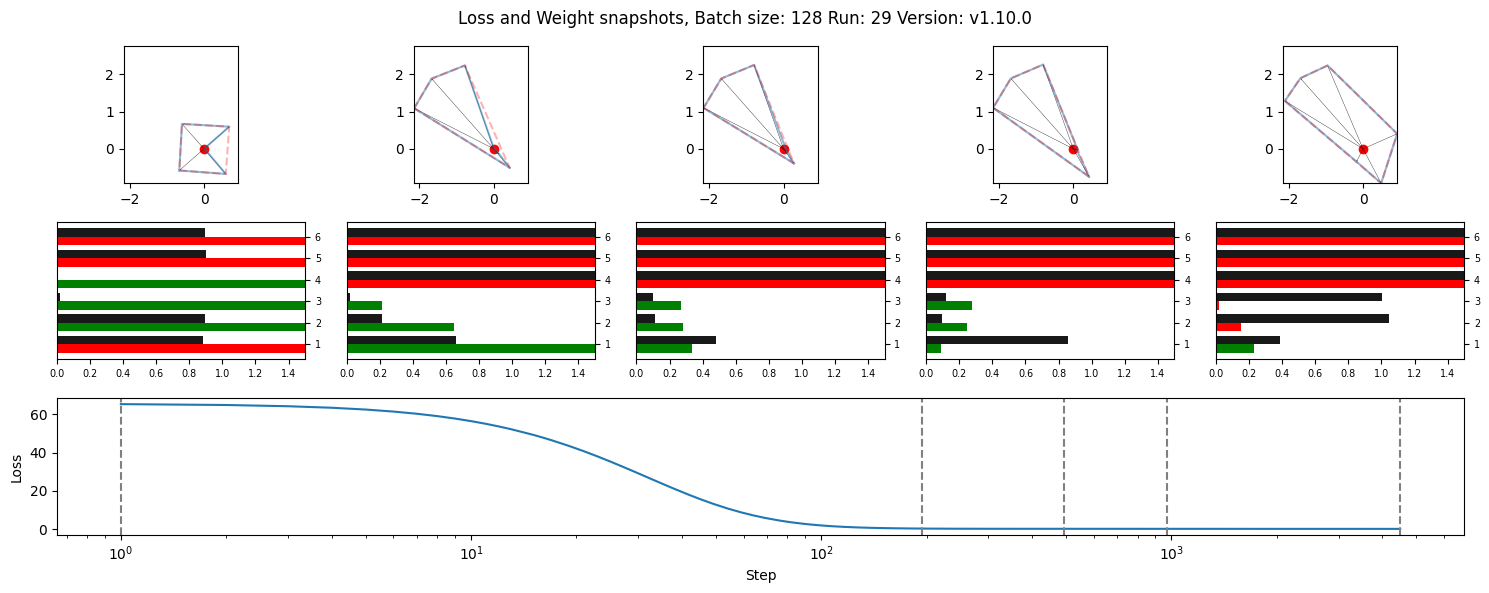

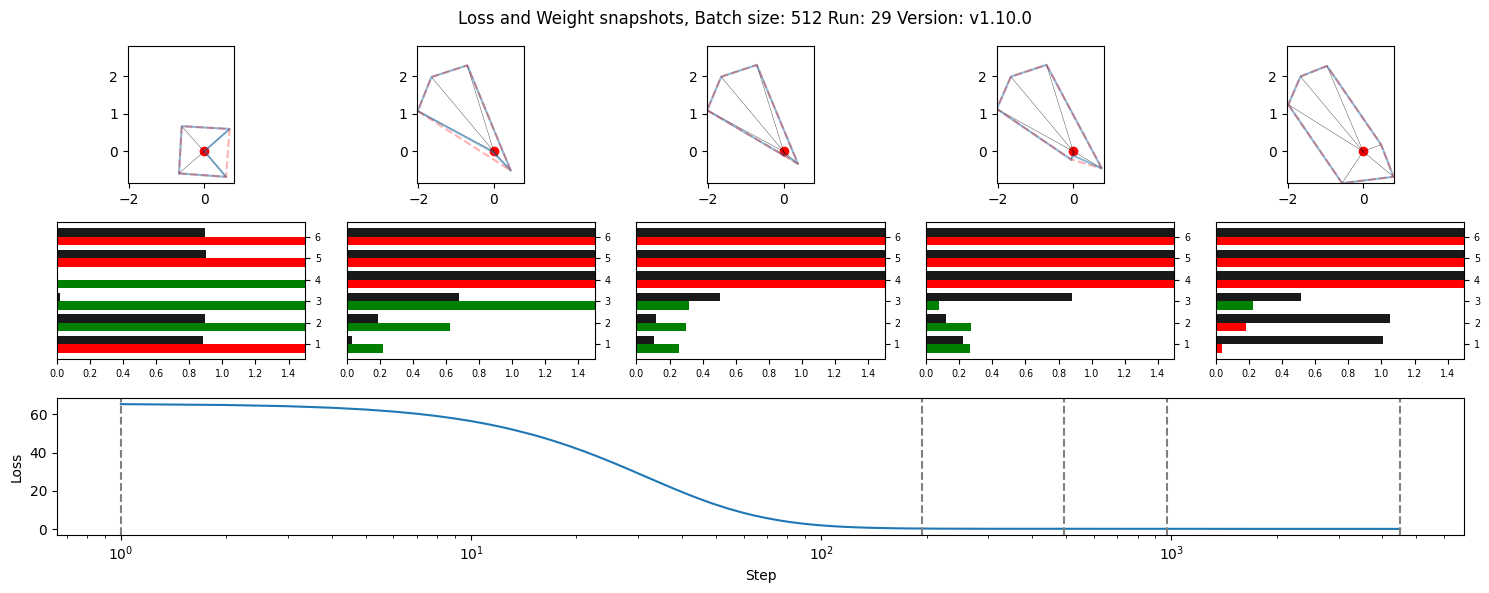

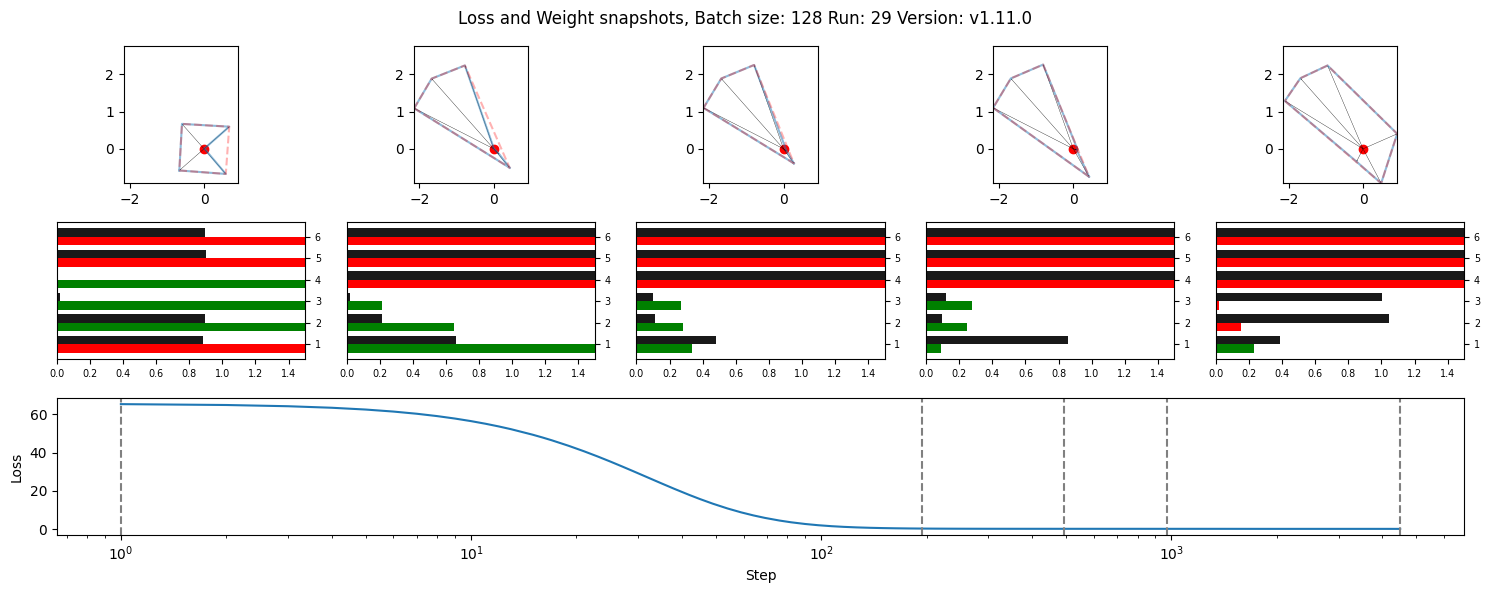

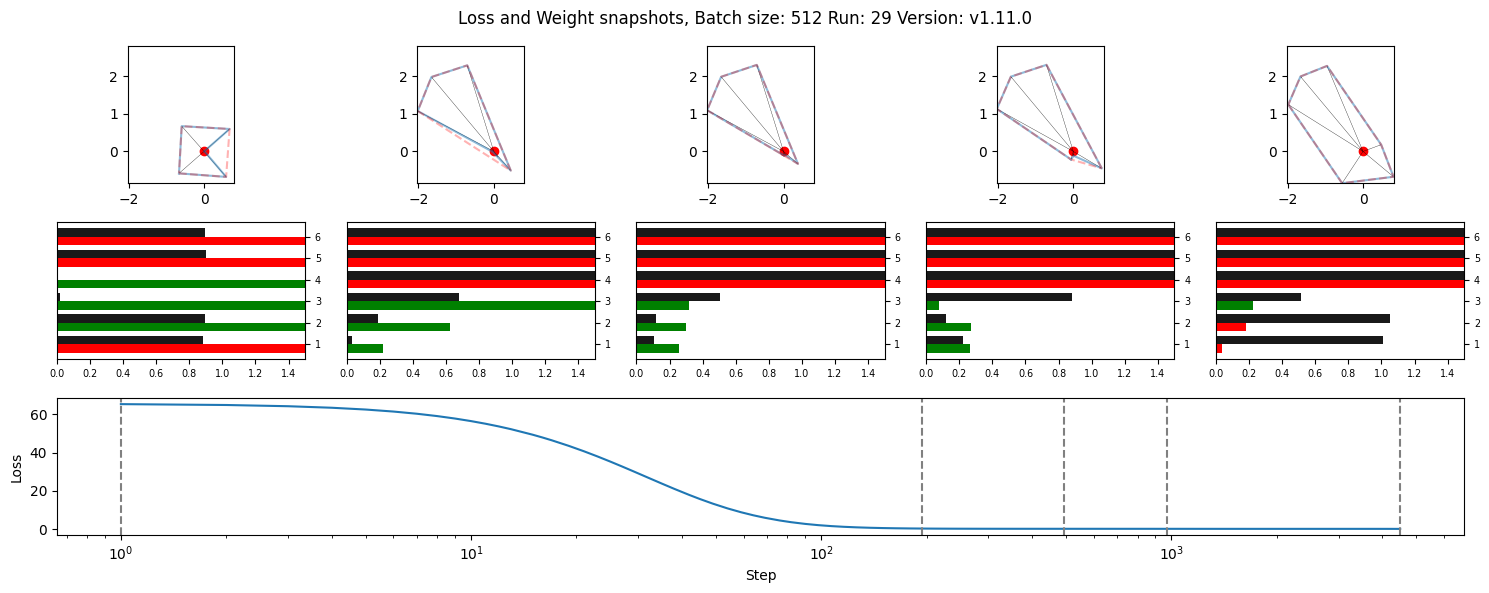

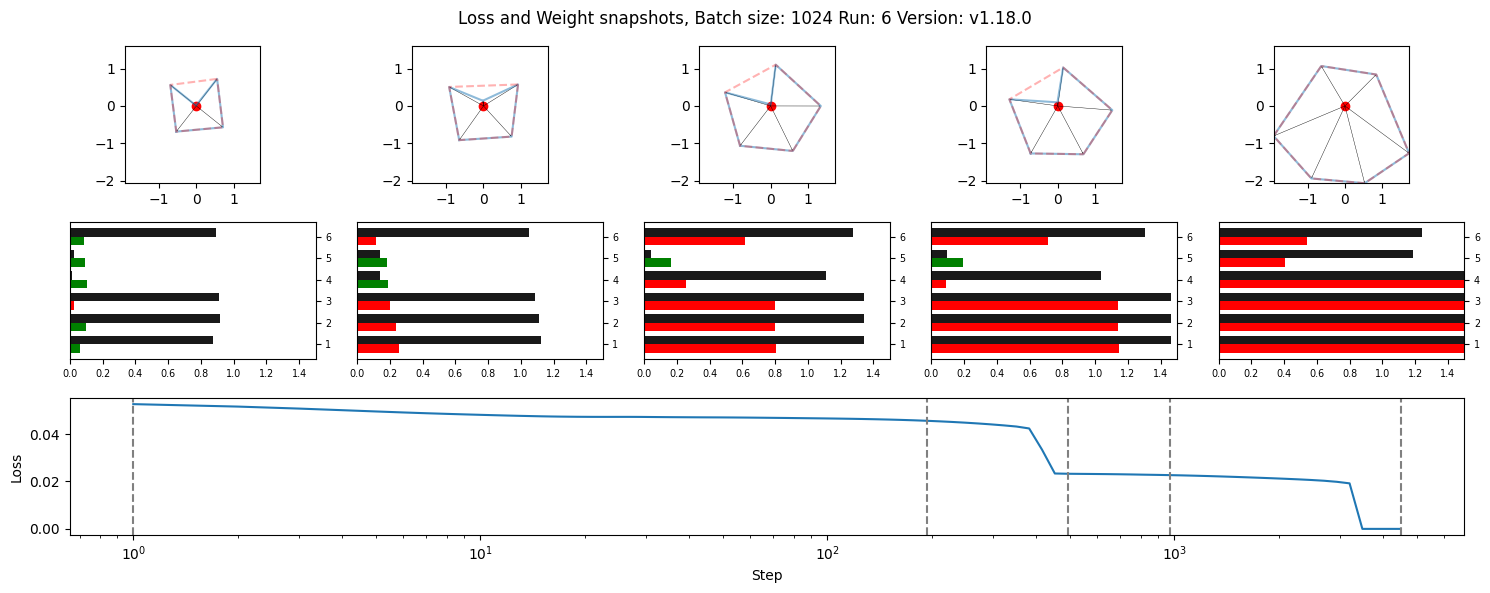

In [82]:
#version = "v1.6.0"
for version in versions.keys():
    if versions[version]["num_hidden_units"] > 2 or versions[version]["num_features"]> 8:
        continue
    for batch_size in batch_sizes[version]:
        for run in range(versions[version]["num_runs"]):
            all_weights = batch_weights[version][batch_size]
            last_weights = all_weights[run][-1]['embedding.weight']
            k = calculate_convex_hull_vertices(last_weights)
            if k == 6:
                weights_to_plot = [all_weights[run][i]['embedding.weight'] for i in PLOT_INDICES[version]]
                all_logs = batch_logs[version][batch_size]
                biases = [all_weights[run][i]['unembedding.bias'] for i in PLOT_INDICES[version]]
                losses = [all_logs[run].loc[all_logs[run]['step'] == s, 'loss'].values[0] for s in STEPS[version]]
        
                plot_losses_and_polygons(STEPS[version], losses, PLOT_STEPS[version], weights_to_plot,biases=biases, batch_size=batch_size, run=run, version=version,yscale='linear')
                #plt.savefig(f"results/batch_{batch_size}_run_{run}_losses_{version}.png")
                plt.show()


Here the first run with every different version:

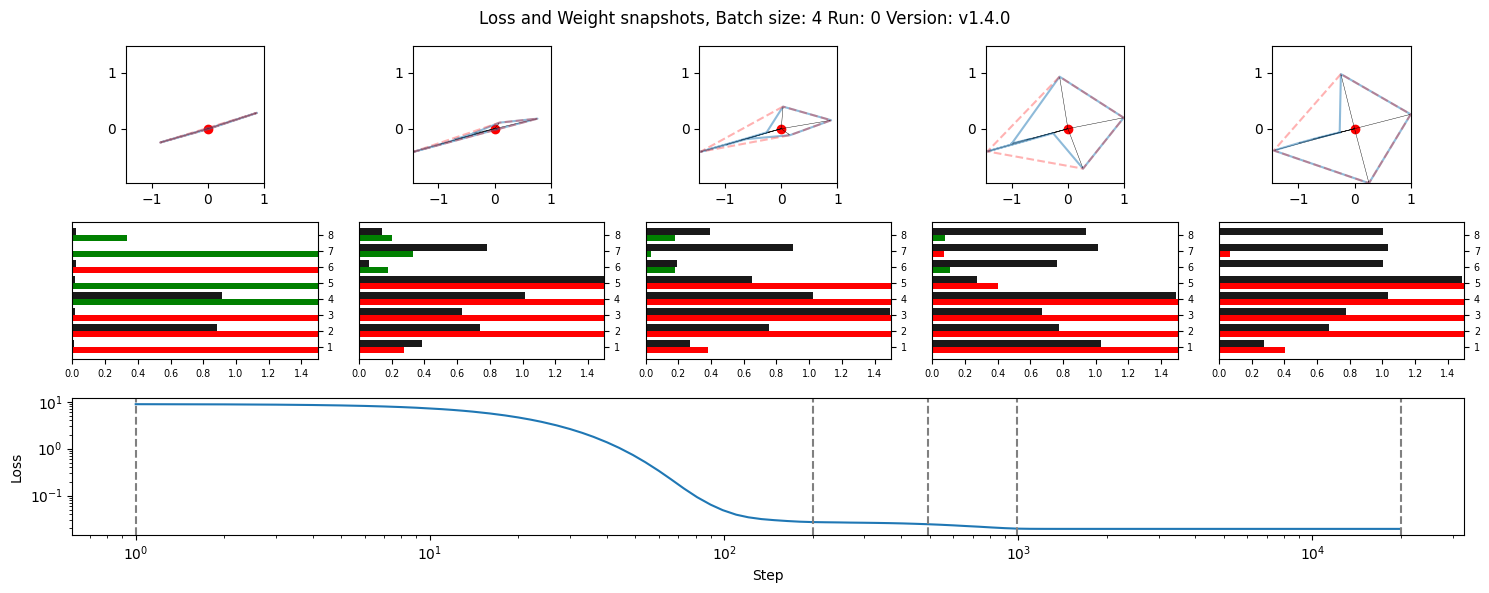

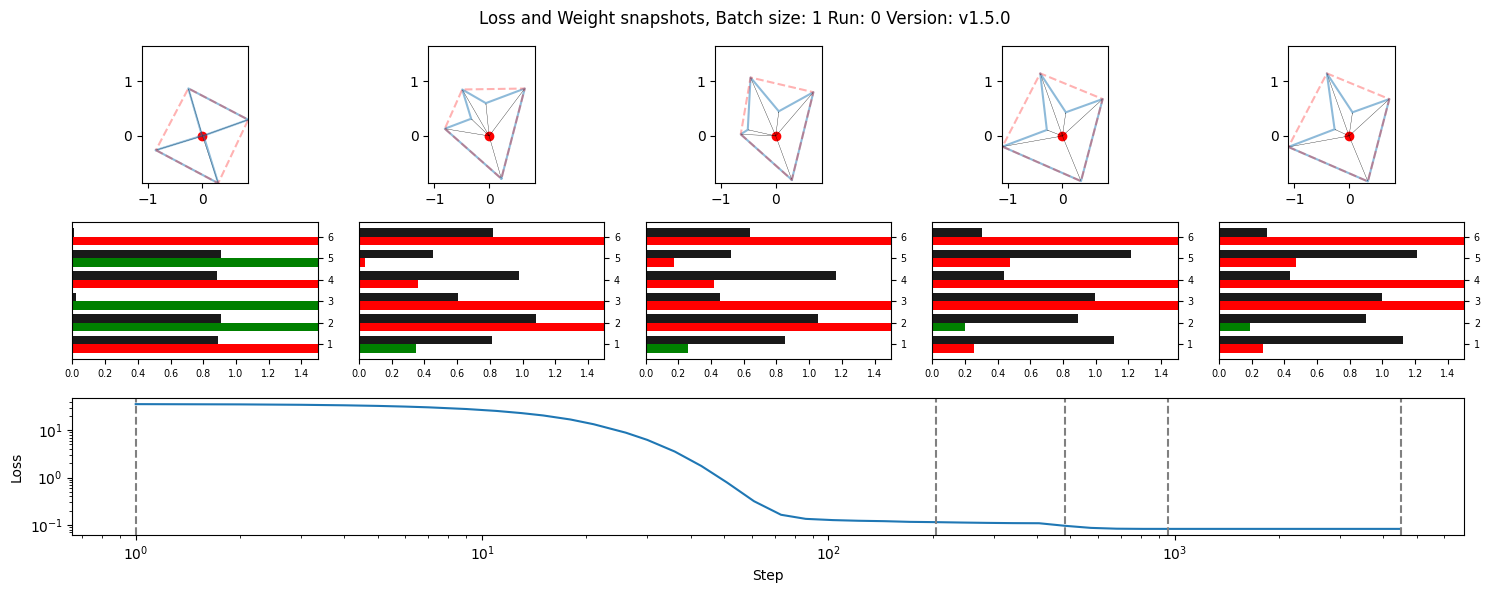

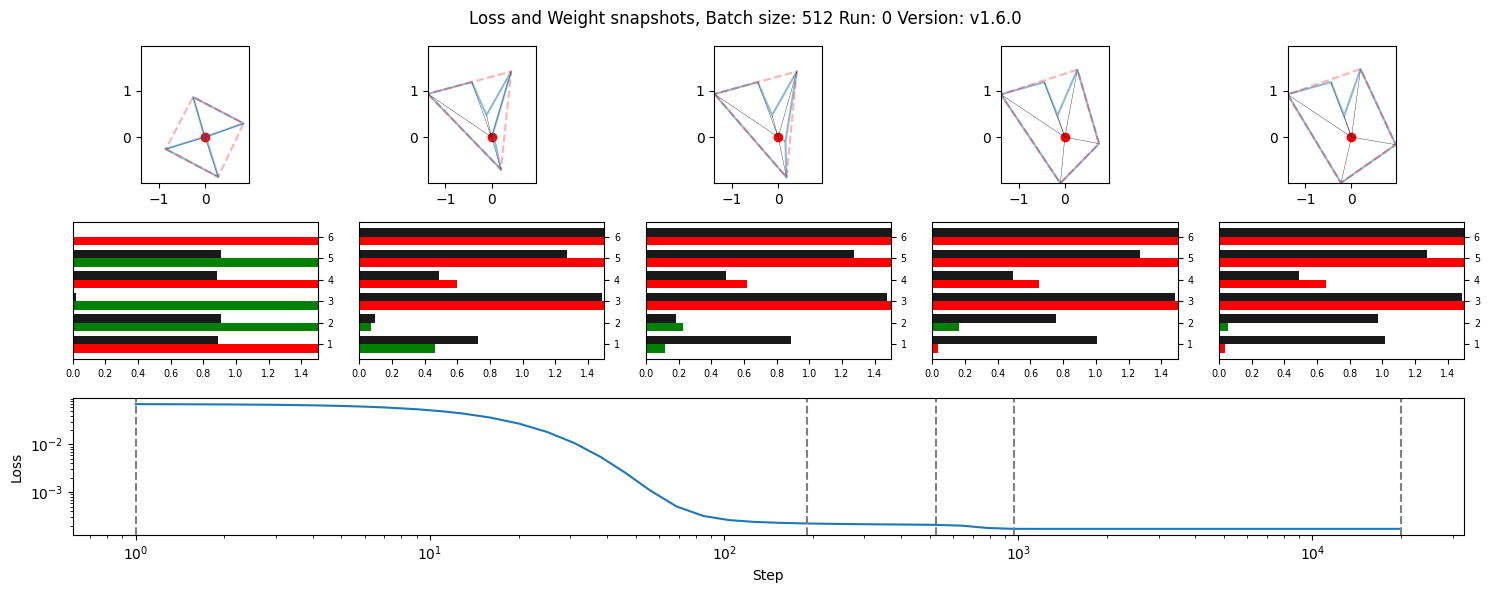

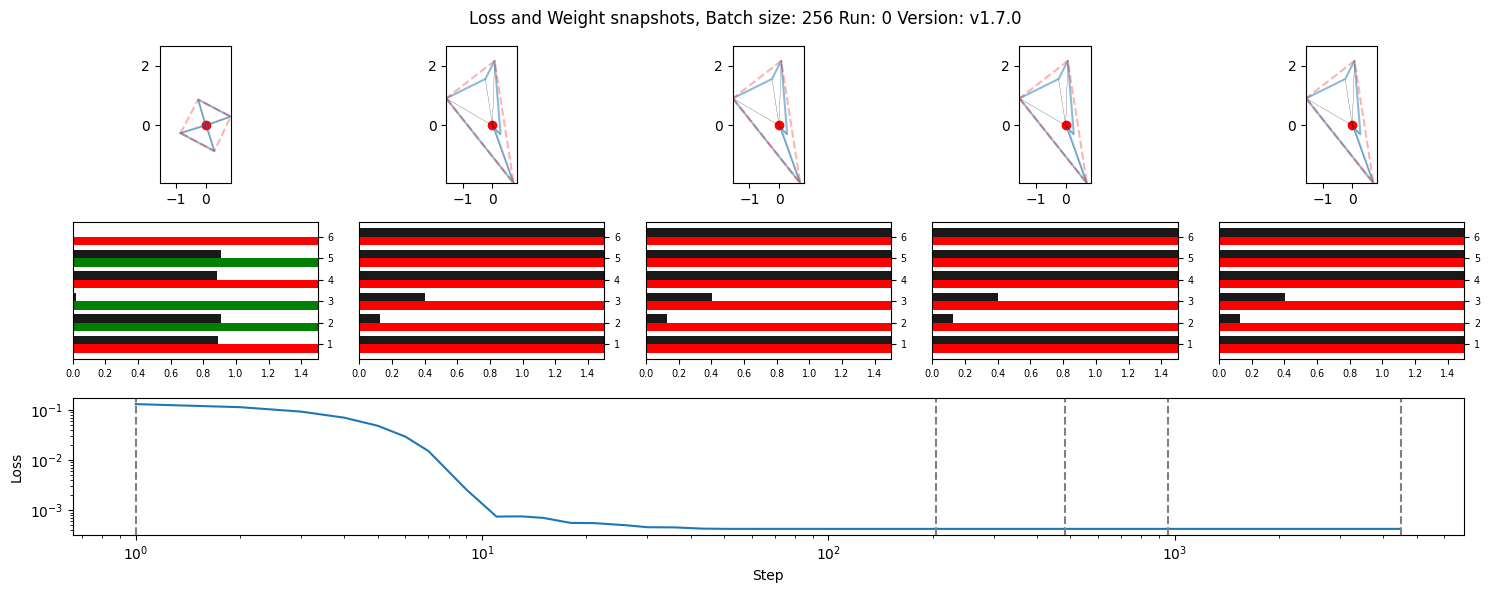

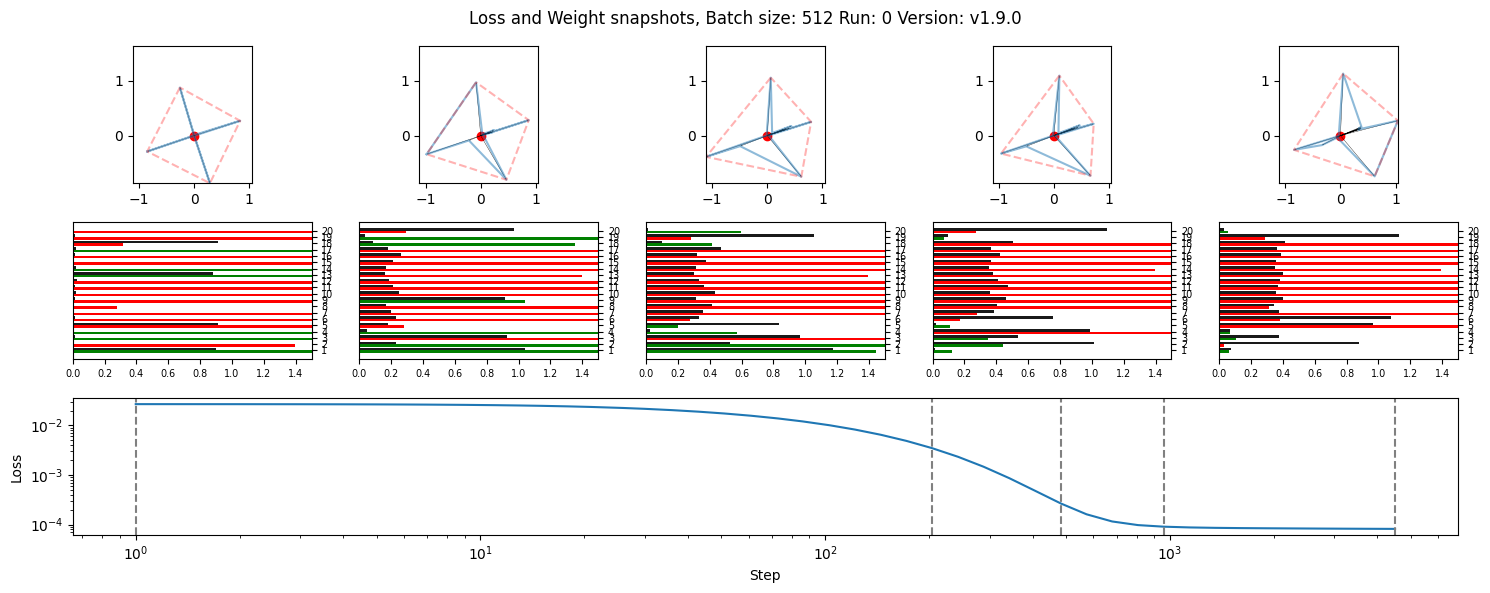

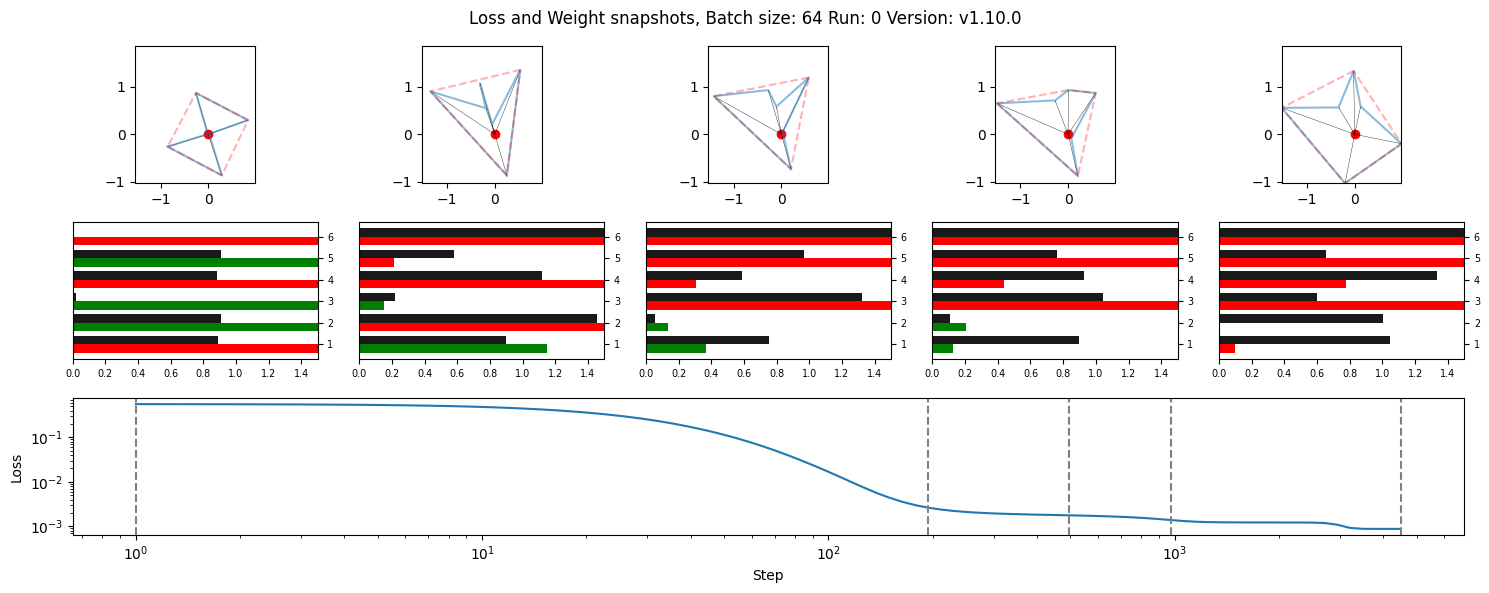

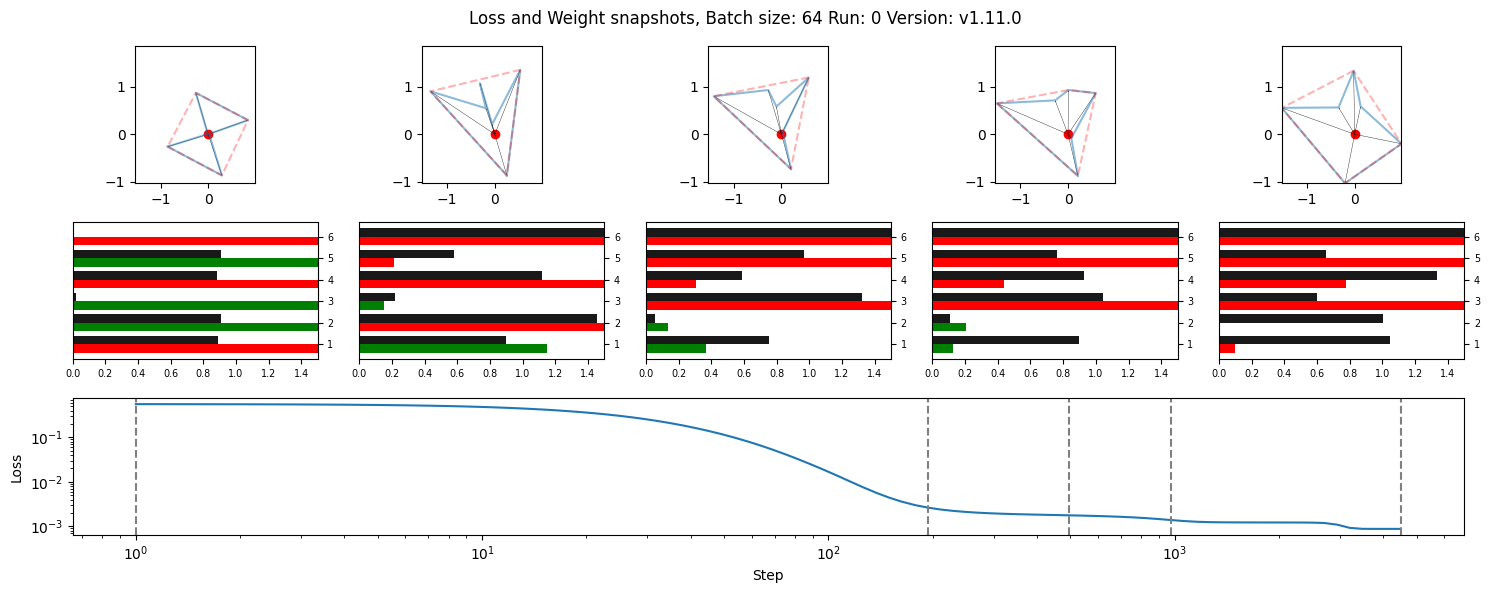

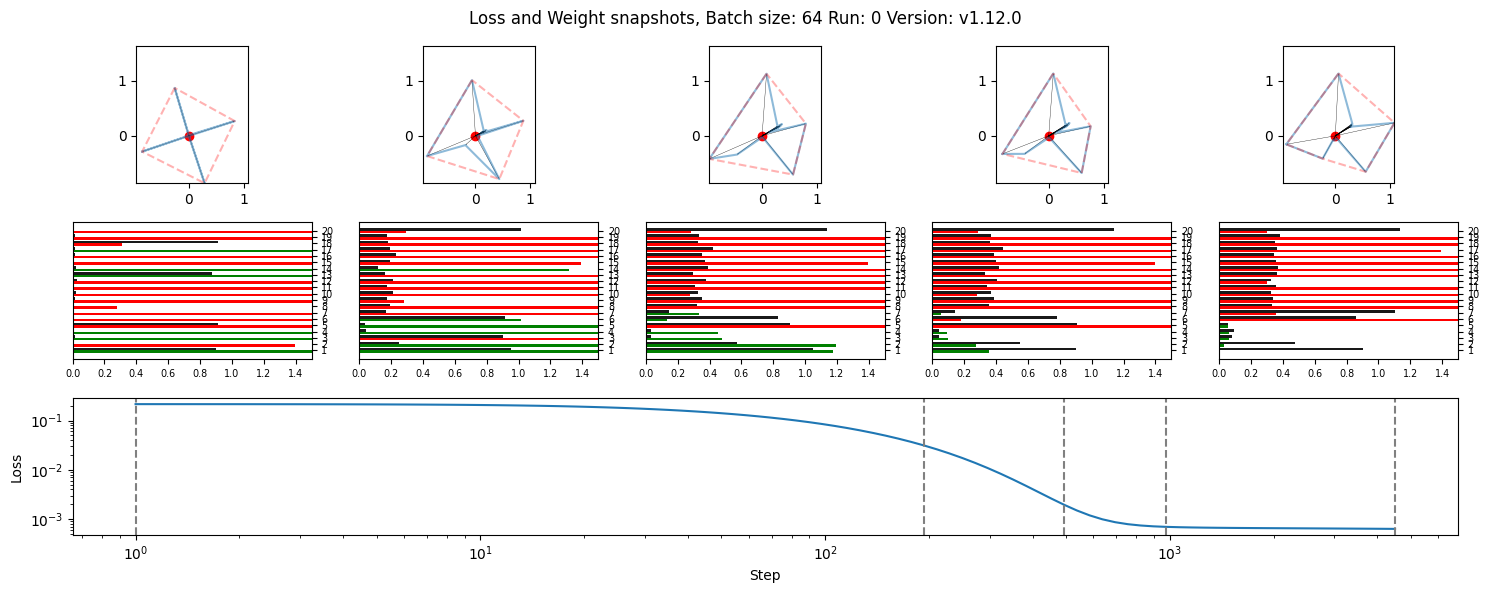

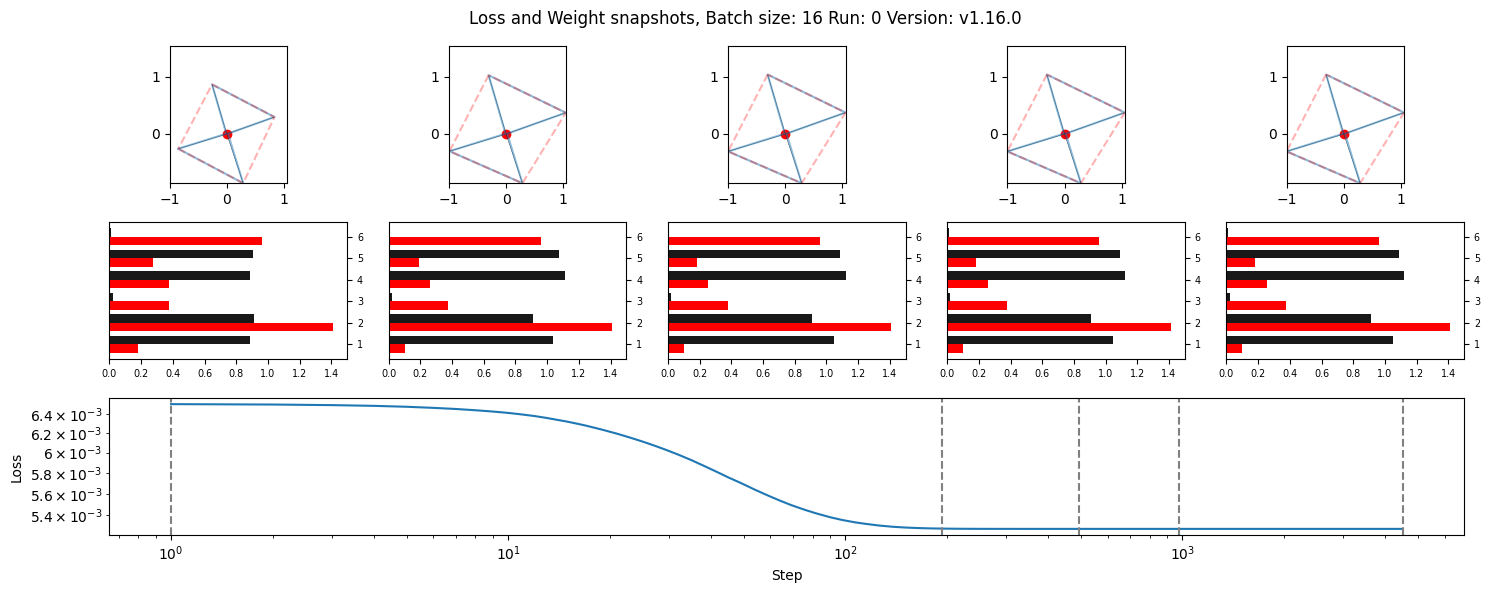

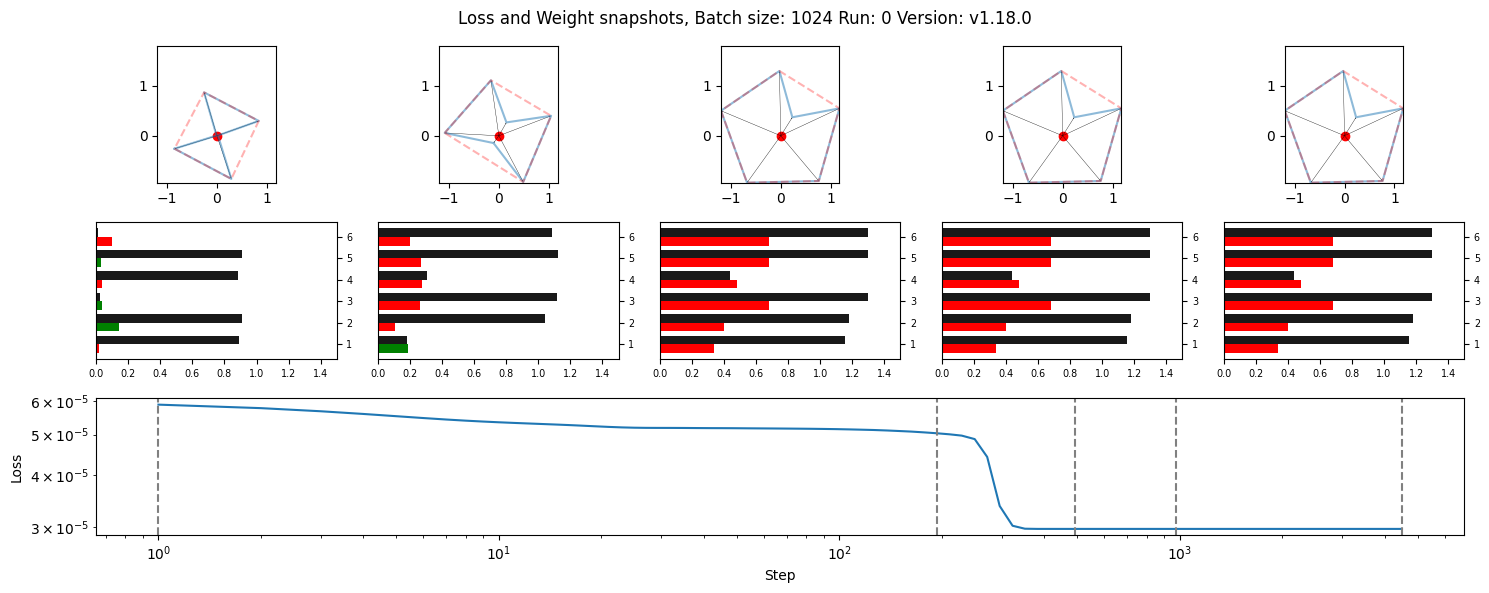

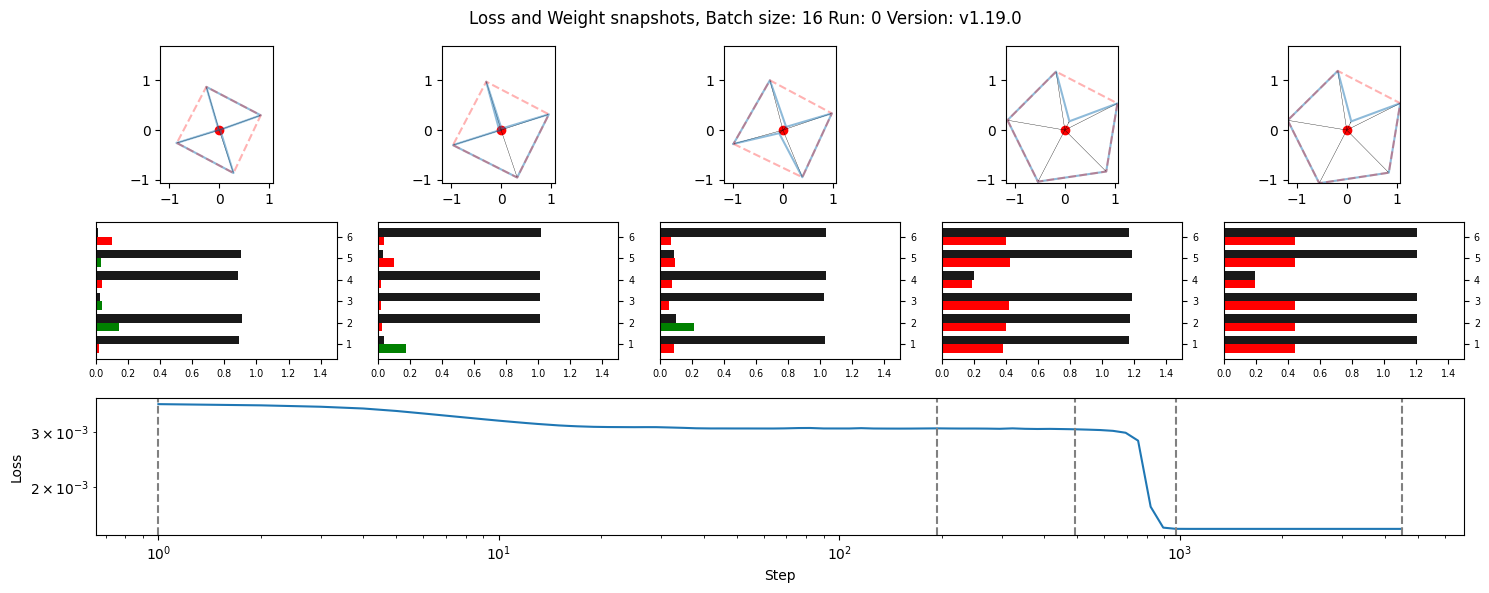

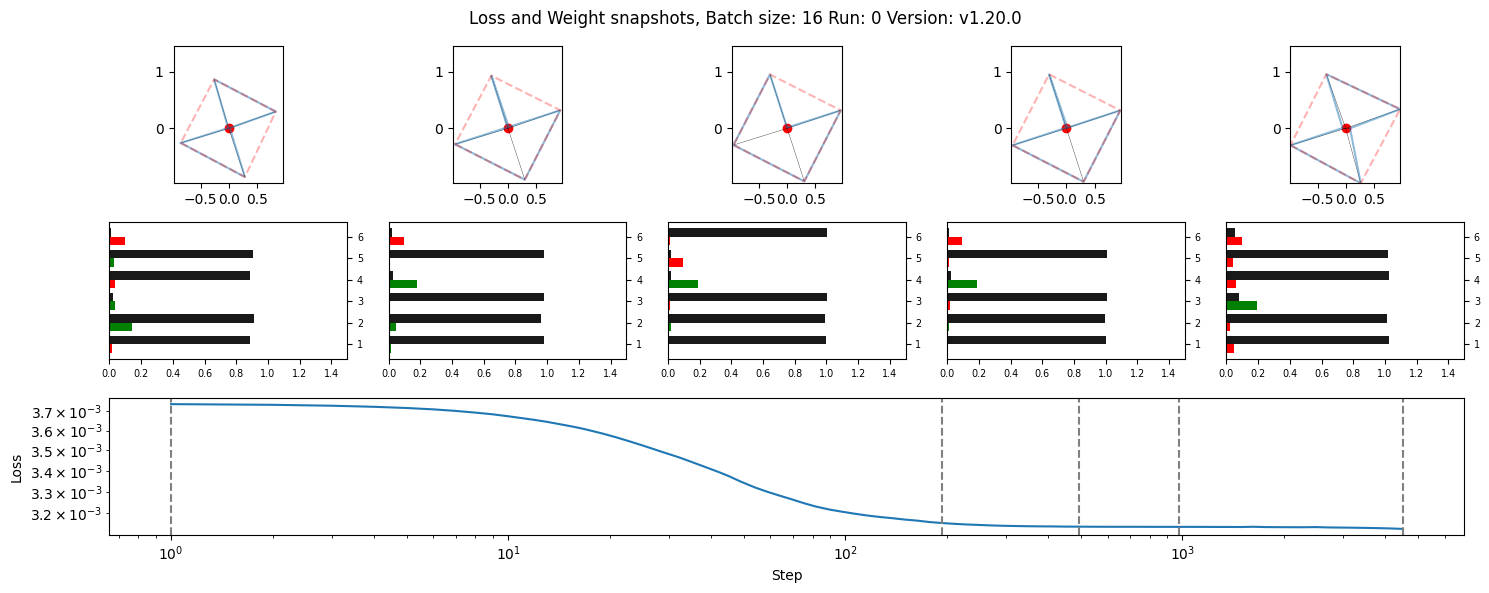

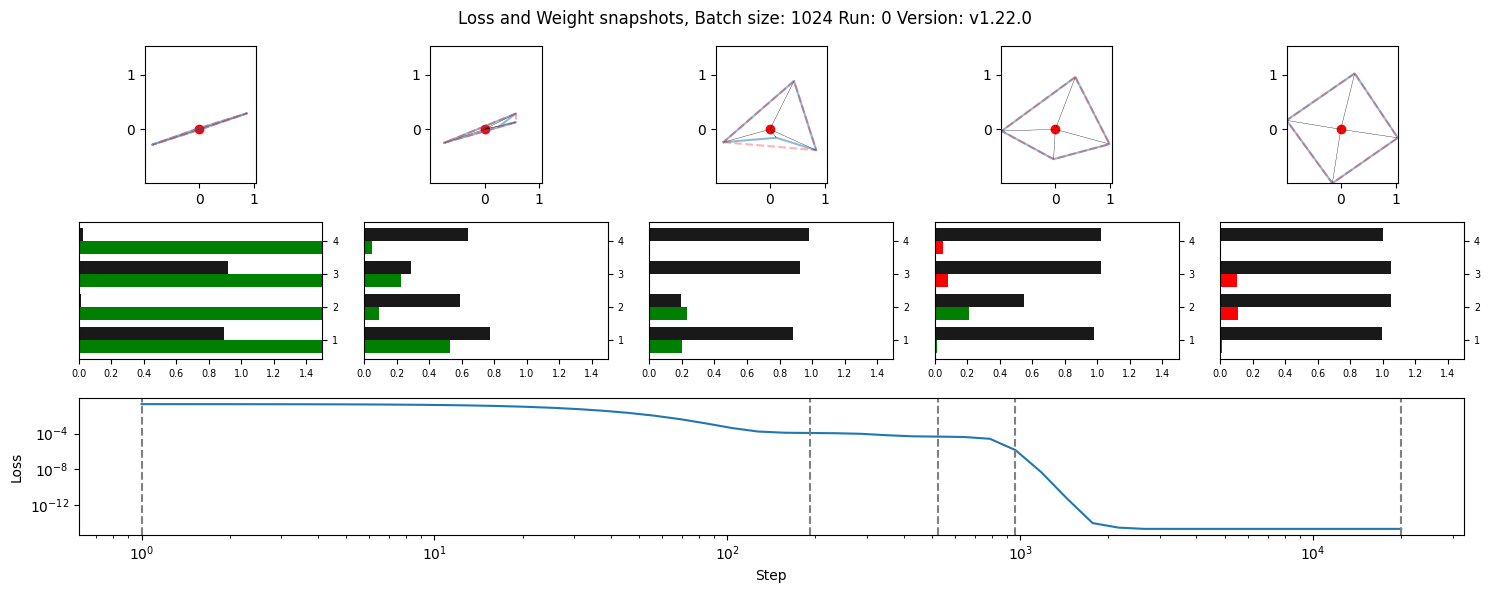

In [33]:
for version in versions.keys():
    if versions[version]["num_hidden_units"] > 2:
        continue
    for batch_size in batch_sizes[version]:
        #if batch_size not in [1024, 16]:
        #    continue
        for run in range(versions[version]["num_runs"]):
            all_weights = batch_weights[version][batch_size]
            all_logs = batch_logs[version][batch_size]
            weights_to_plot = [all_weights[run][i]['embedding.weight'] for i in PLOT_INDICES[version]]
            
            biases = [all_weights[run][i]['unembedding.bias'] for i in PLOT_INDICES[version]]
            #print(biases,"\n")
            #print("biases:",biases)
            losses = [all_logs[run].loc[all_logs[run]['step'] == s, 'loss'].values[0] for s in STEPS[version]]
            plot_losses_and_polygons(STEPS[version], losses, PLOT_STEPS[version], weights_to_plot,biases=biases, batch_size=batch_size, run=run, version=version)
            #plt.savefig(f"results/batch_{batch_size}_run_{run}_losses_{version}.png")
            plt.show()
            break
        break
        